In [1]:
import os
import subprocess
import numpy as np
import mdtraj as md
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, widgets

matplotlib.rcParams['figure.figsize'] = (8.25, 8.25)
matplotlib.rcParams.update({'font.size': 20})

In [2]:
# WARNING! Interacting graphs require %matplotlib notebook
# but you will need to re-enable %matplotlib inline afterwards to view normal graphs
%matplotlib inline

In [3]:
#path to catdcd (needed for writing output files), included in any VMD installation
catdcdPath = "/home/trayder/src/vmd-1.9.4a57/plugins/LINUXAMD64/bin/catdcd5.2/catdcd"

SMD preparation and execution
========

Obtain dcd/xst trajectory
Preferably with same colvars as you intend to use

# String Method preparation


In [4]:
# Define the PDB and PSF files for future use along the notebook.
#pdbFile = "./pull_system_reduced.pdb"
psfFile = "./pull_traj/crystal.xplor.ext.hmr.psf"
dcdFile = "./pull_traj/slow_run_14_full.dcd"

#Adjust stride if too large
traj = md.load(dcdFile, top=psfFile, stride=1)[14000:18500]

# Location of String Method setup and output folders.
basePath = "./"
setupPath = basePath + "/setup/"
outputPath = basePath + "/output/"

### Define atom groups for CVs

In [5]:
'''Define specific indices needed for collective variables'''

#resid 271
lys_NZ_index = [600]
#resid 286
glu_CD_index = [851]
#resid 381
asp_CG_index = [2391]

#Imat fragments from abl_data/pull_system_reduced.pdb:
#1
imat1_indices = [4266, 4267, 4269, 4271, 4273, 4275]
#2
#Fragments 1 and 2 are planar but flip
imat2_indices = [4276, 4278, 4279, 4280, 4282, 4283]
#3
imat3_indices = [4286, 4287, 4292, 4294, 4296, 4298]
#4
imat4_indices = [4303, 4304, 4306, 4308, 4310, 4312]
#5
imat5_indices = [4313, 4319, 4322, 4325, 4328, 4331]

imat_frags = []
imat_frags.append(imat1_indices)
imat_frags.append(imat2_indices)
imat_frags.append(imat3_indices)
# imat_frags.append(imat4_indices)
# imat_frags.append(imat5_indices)

# Conserved aC salt-bridge
residue_271 = traj.topology.select("resSeq 271 and protein and not element He")
residue_286 = traj.topology.select("resSeq 286 and protein and not element He")
# Aloop to 310
residue_386 = traj.topology.select("resSeq 386 and protein and not element He")

### Choose collective variables

In [6]:
def append_CV_dict(CV_dict, group1, group2):
    '''Constructs nested dictionaries'''
    if CV_dict.keys():
        next_num = np.amax([int(i) for i in CV_dict.keys()])+1
    else:
        next_num = 1
    CV_dict[str(next_num)] = {"a":group1, "b":group2}

In [7]:
def smooth_traj(traj=None, w=1):
    beg_pad = [np.mean(traj[:w])]*w
    end_pad = [np.mean(traj[-w:])]*w
    smooth_traj = np.convolve(beg_pad+list(traj)+end_pad, np.ones(w)/w, mode='same')[w:-w]
    return smooth_traj

In [8]:
def resid_to_index(resid=None,traj=traj):
    return traj.topology.atom(traj.topology.select("protein and name CA and resSeq "+str(resid))[0]).residue.index

In [9]:
def featurize_traj(traj,imat_frags=None, selected_residues=None):
    '''Create featurization of trajectory
    In this case the closest contact between ligand atoms (imat_frags) and selected_residues of the protein
    '''
    featurized = np.zeros((0,len(imat_frags),traj.n_frames))
    include_residues = []

    for residue in traj.topology.residues:
        print(".", end="")
        if selected_residues:
            if not (residue.resSeq in selected_residues):
                continue
        elif not residue.is_protein:
            break

        res_indices = [atom.index for atom in residue.atoms if atom.element.atomic_number > 1]
        #res_indices = [atom.index for atom in residue.atoms if atom.name == 'CA']
        res_xyz = traj.xyz[:,res_indices]
        
        imat_res_feat = np.zeros((0,traj.n_frames))
        for frag in imat_frags:
            frag_com = md.compute_center_of_mass(traj.atom_slice(frag))
            distances = np.linalg.norm(np.expand_dims(frag_com,1)-res_xyz,axis=2)*10
            
            #binary or mindist
            #distances = np.any(distances < 3.5, axis=1)
            distances = np.amin(distances, axis=1)
            
            imat_res_feat = np.vstack((imat_res_feat, distances))
        featurized = np.concatenate((featurized, np.expand_dims(imat_res_feat,axis=0)),axis=0)
    return featurized

In [10]:
featurized = featurize_traj(traj, imat_frags)

.........................................................................................................................................................................................................................................................................

In [11]:
'''number of residues x number of ligand groups x number of frames'''
featurized.shape

(264, 3, 4500)

1 248 0 1842
2 248 1 30


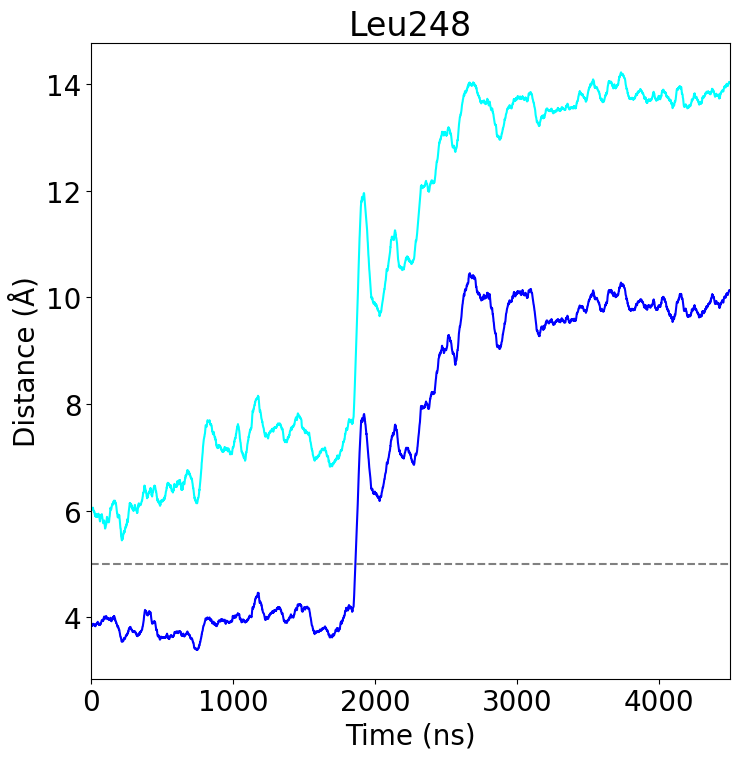

3 249 0 459


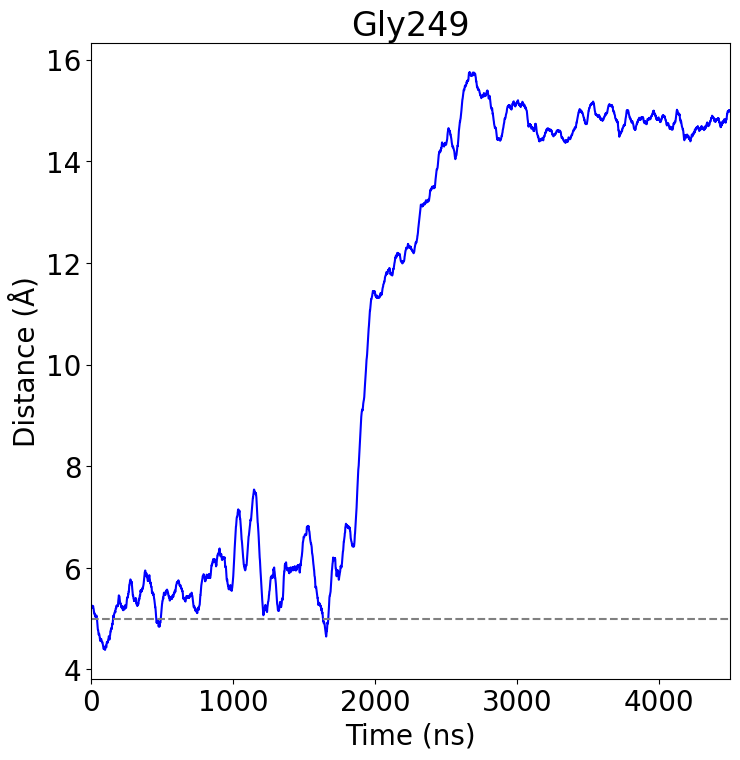

4 253 0 1767
5 253 1 1263


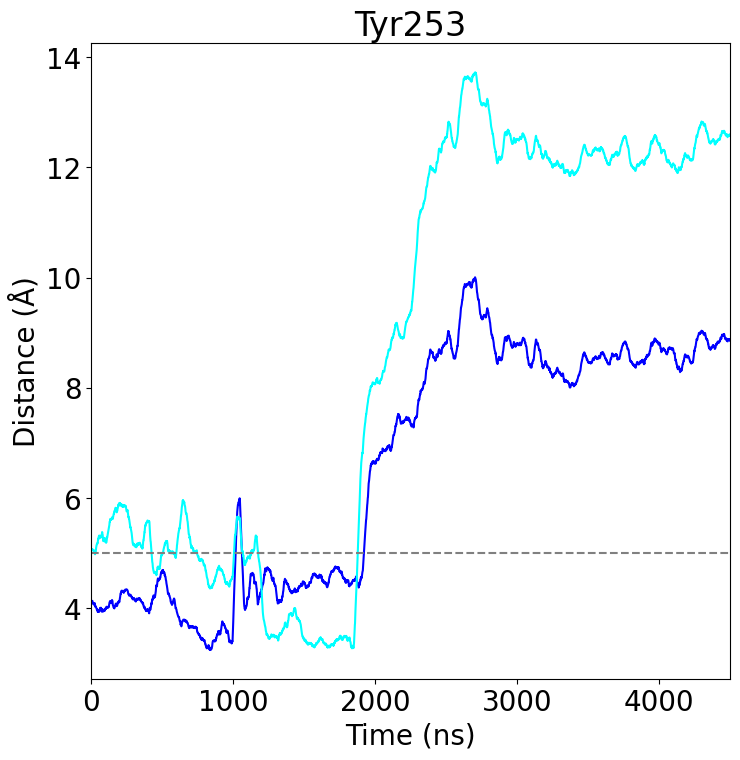

6 254 0 668
7 254 1 883


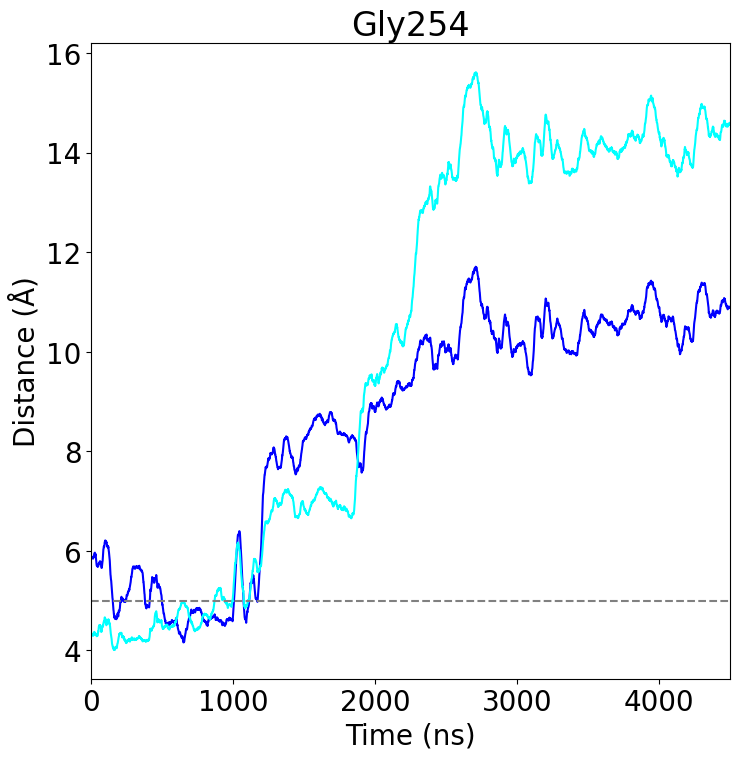

8 255 1 149


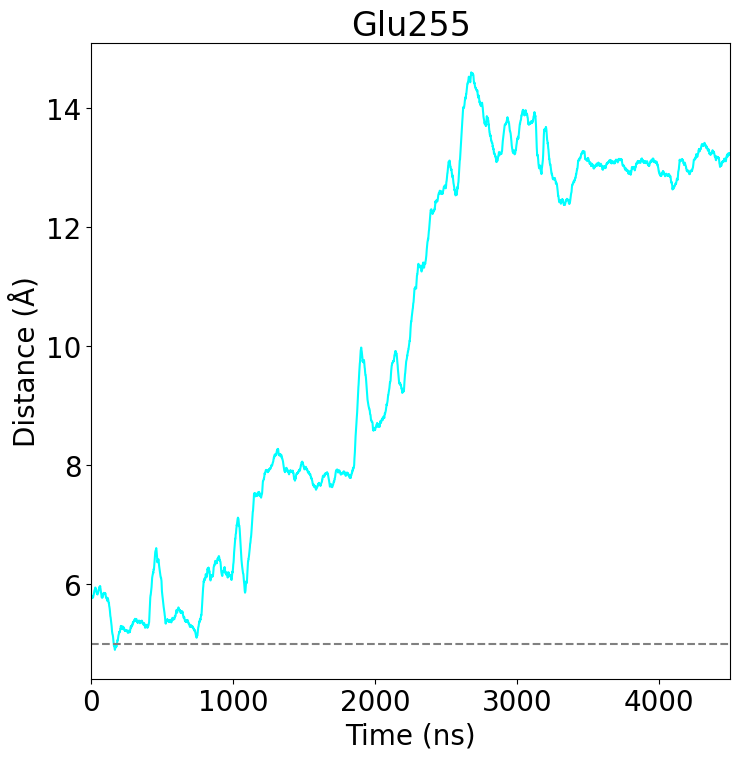

9 256 0 2346
10 256 1 1869
11 256 2 370


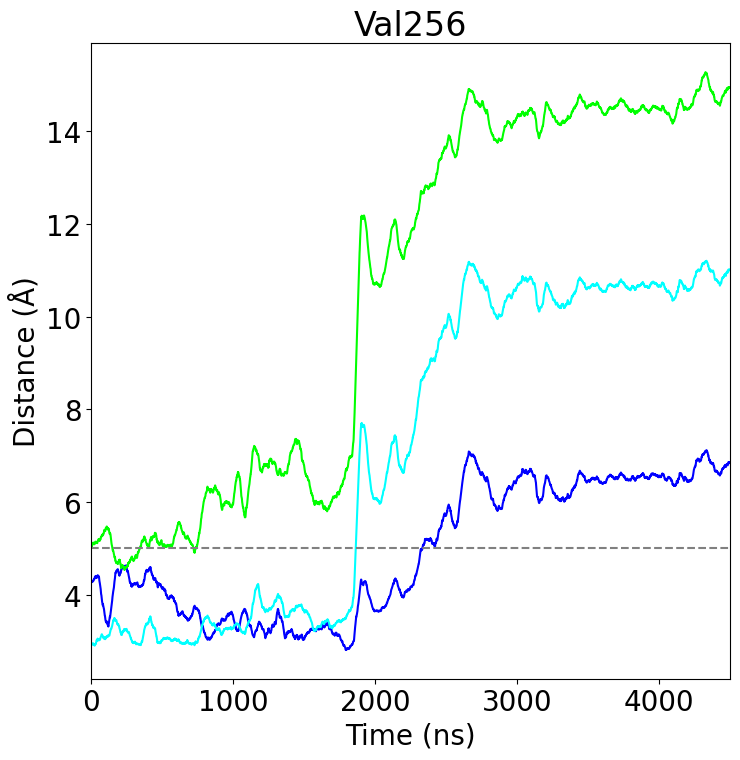

12 269 0 600


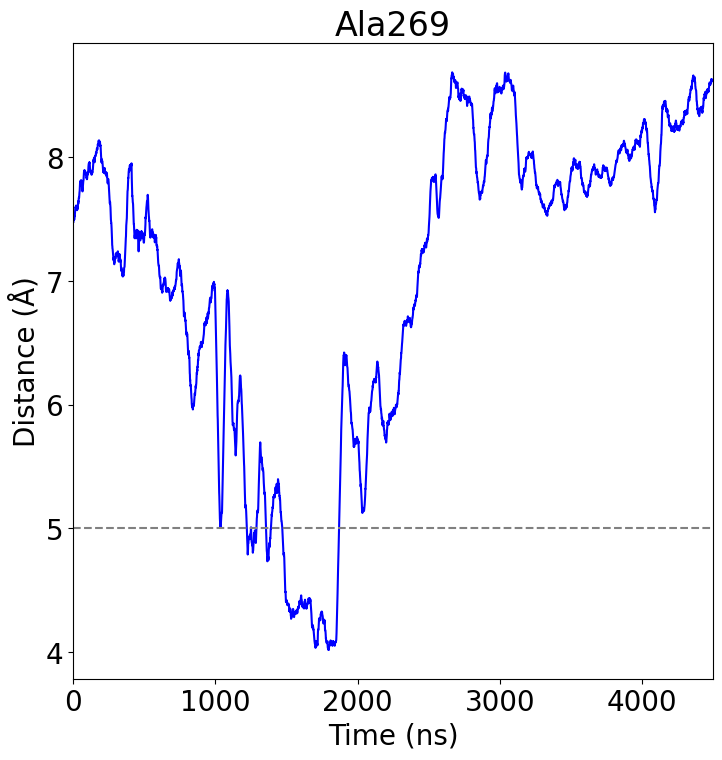

13 271 0 2645
14 271 1 1992
15 271 2 1858


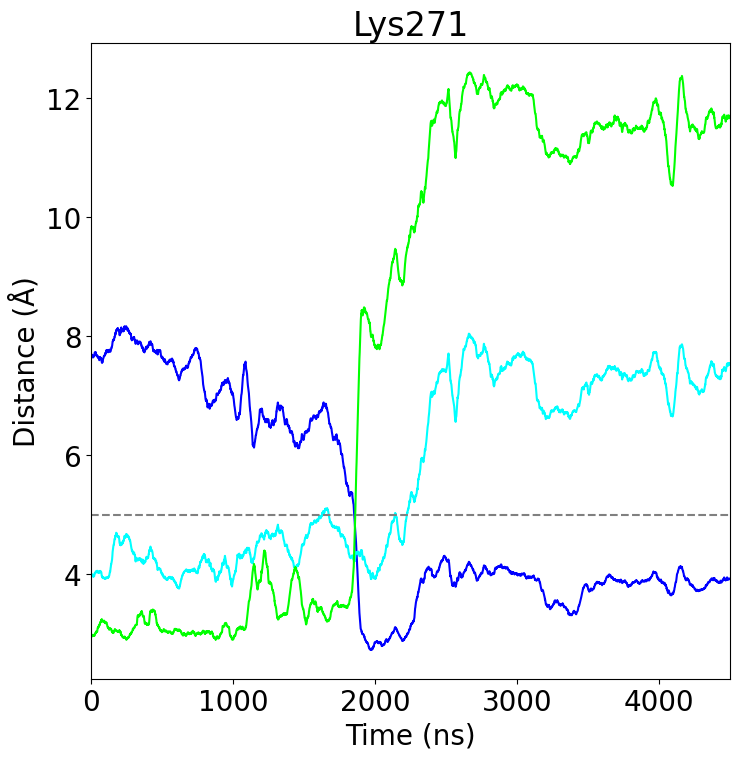

16 273 0 511


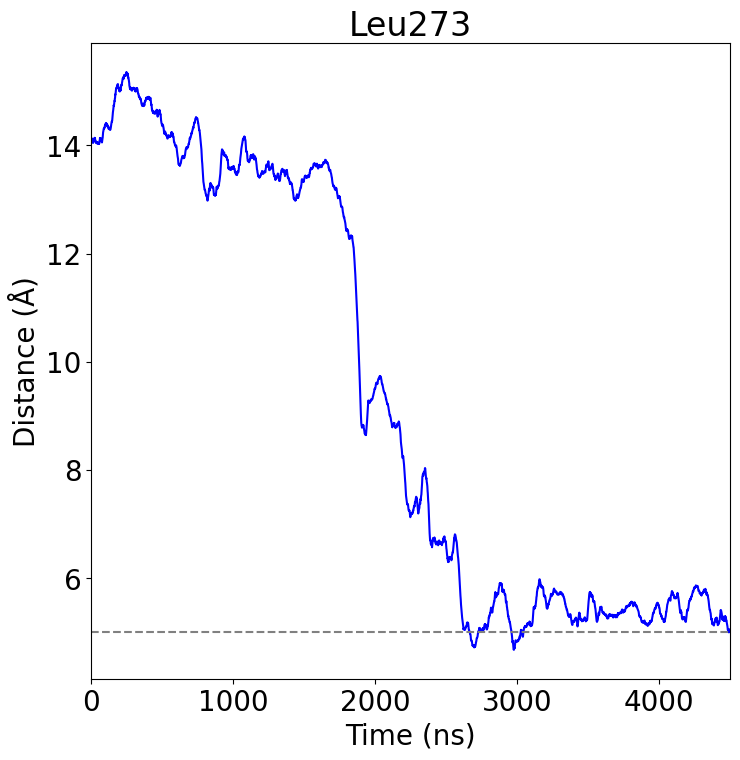

17 283 0 1210
18 283 1 1433


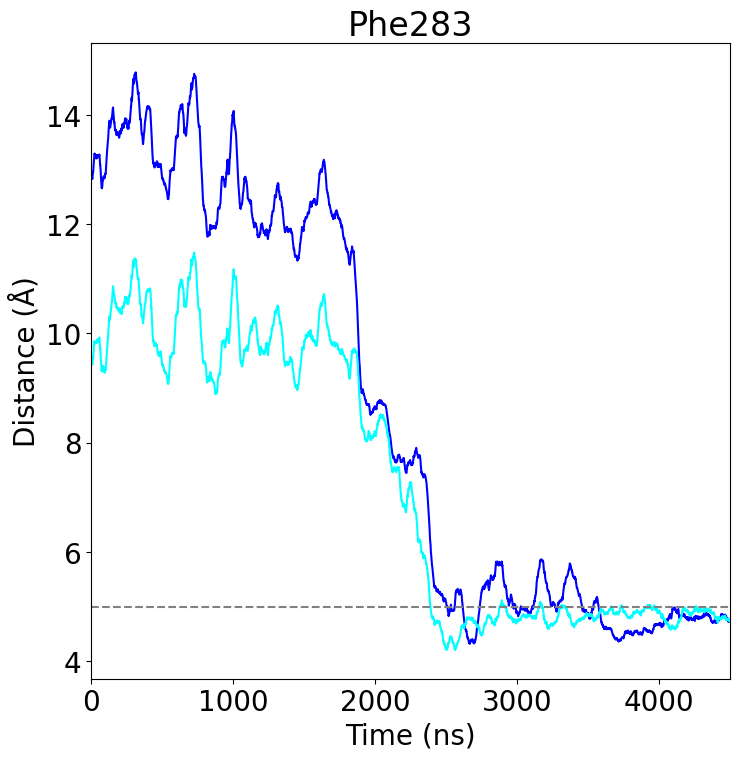

19 286 1 2220
20 286 2 4475


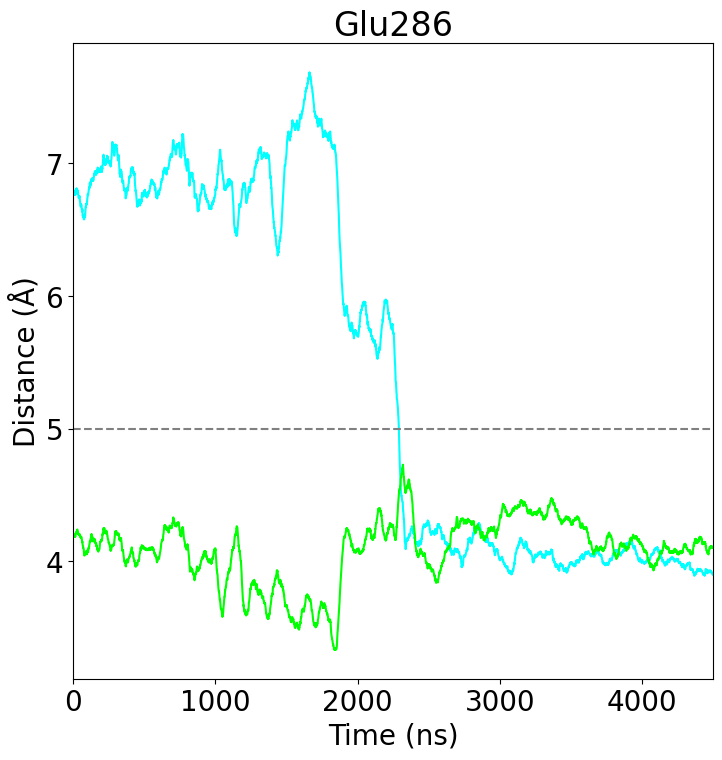

21 287 1 1952


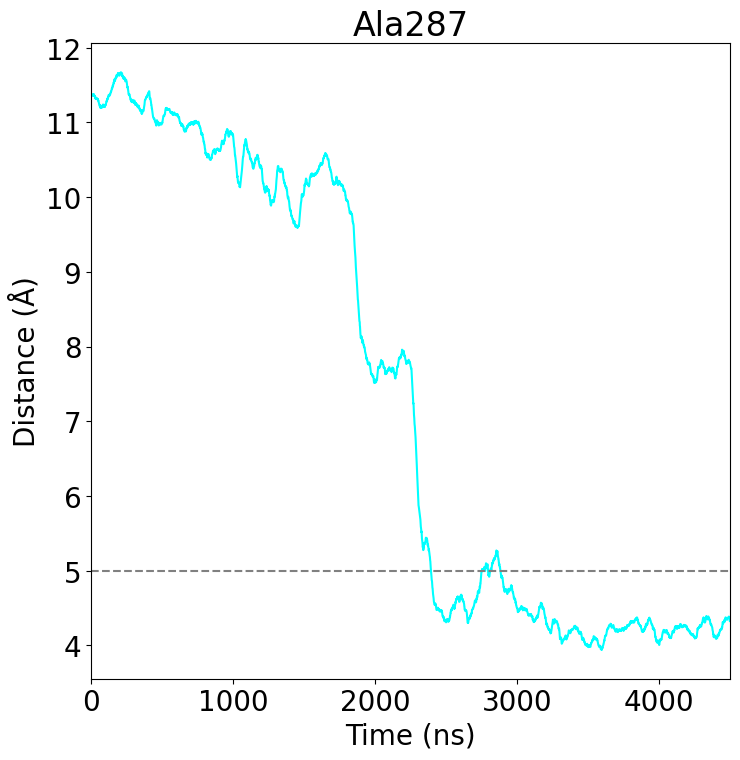

22 289 2 3087


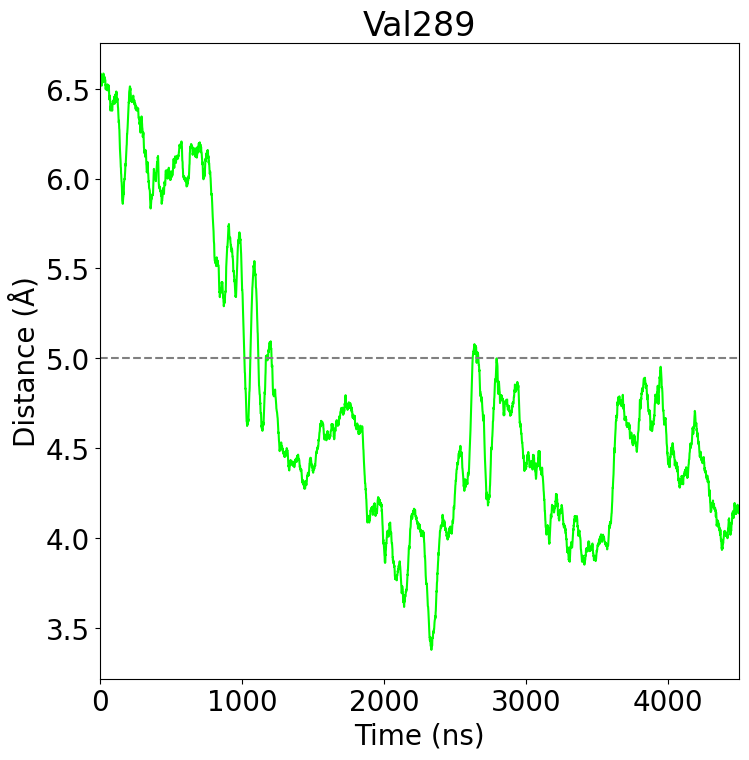

23 290 0 1890
24 290 1 2541
25 290 2 4273


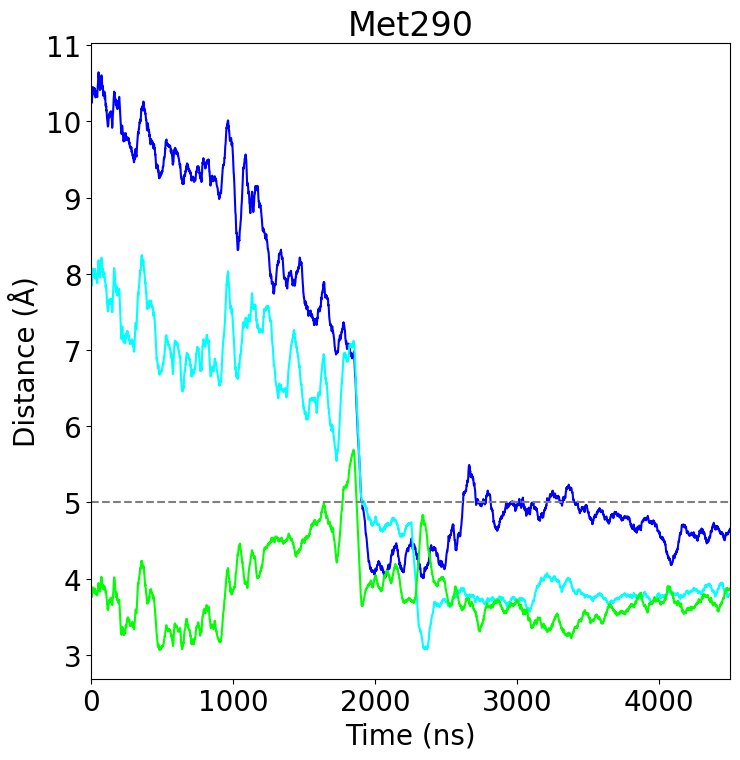

26 293 2 1423


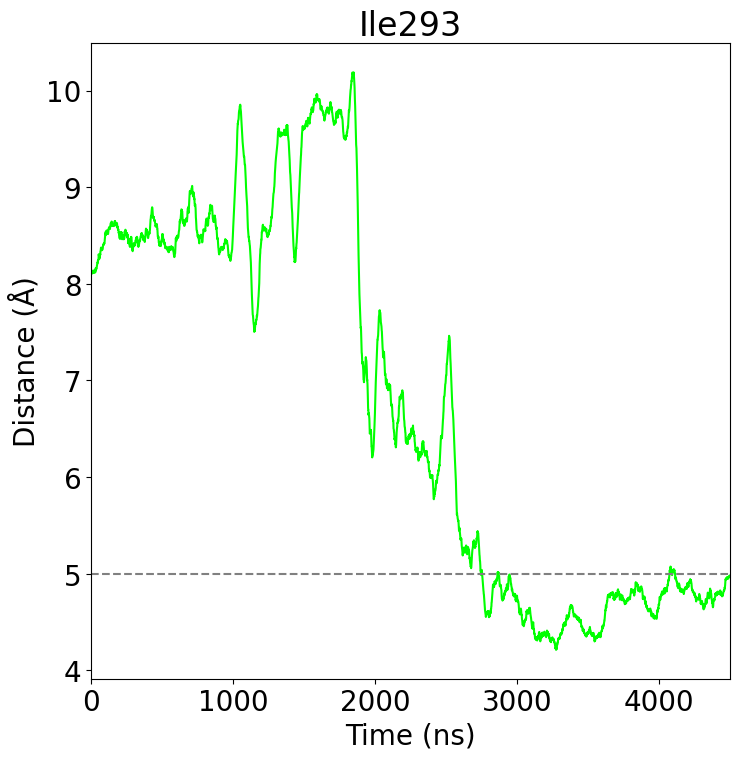

27 301 0 111
28 301 1 395


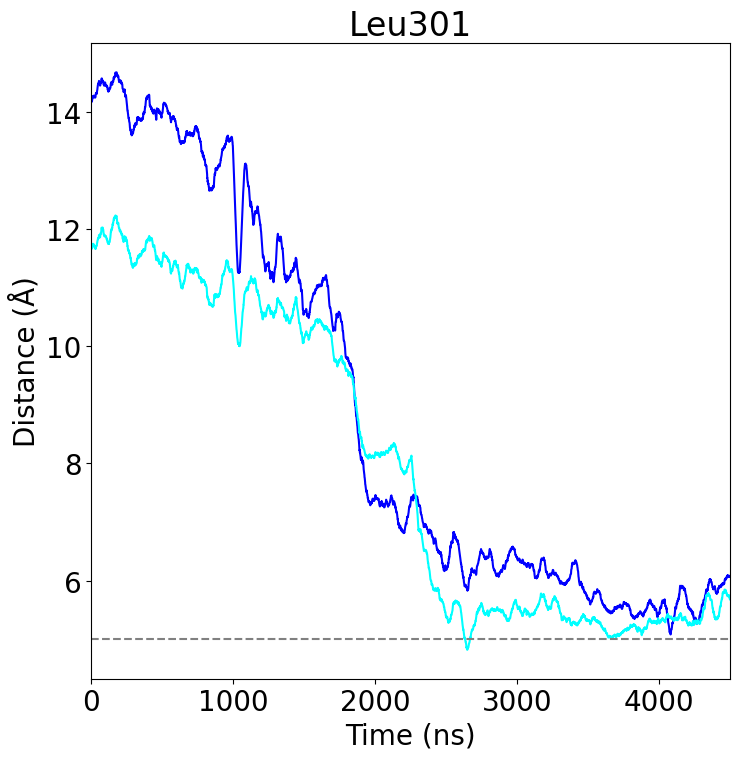

29 313 0 2532
30 313 1 2250
31 313 2 650


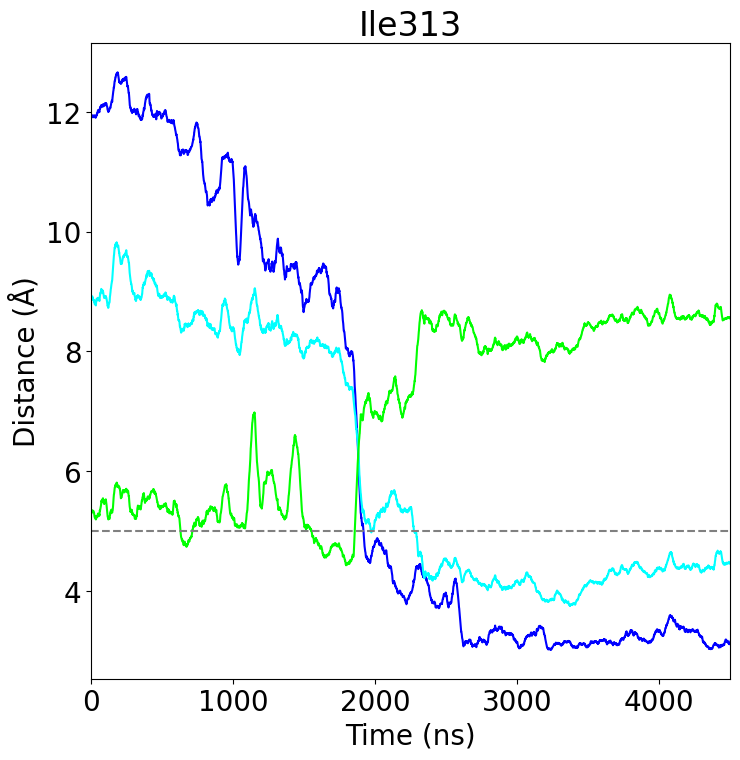

32 315 0 2278
33 315 2 113


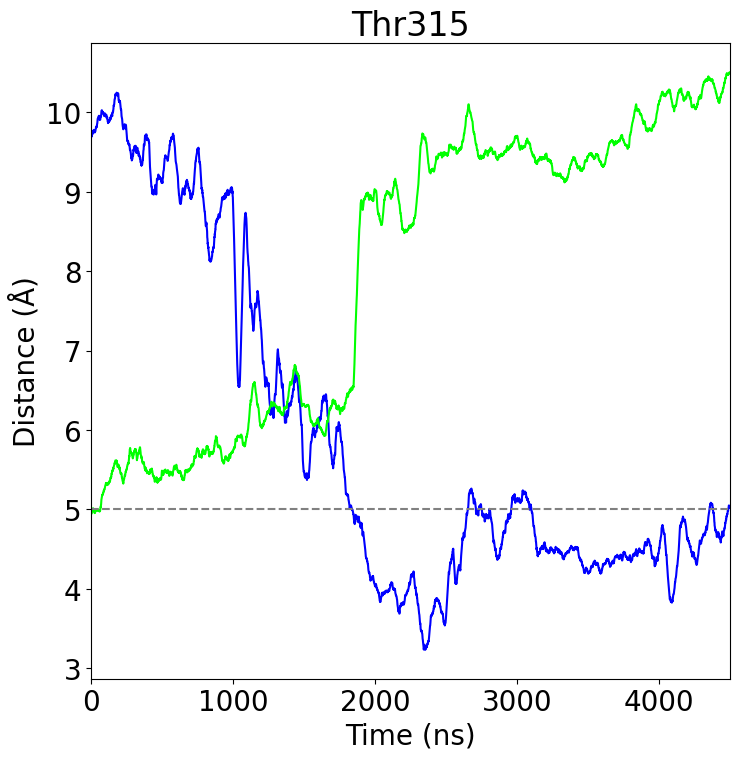

34 317 0 252


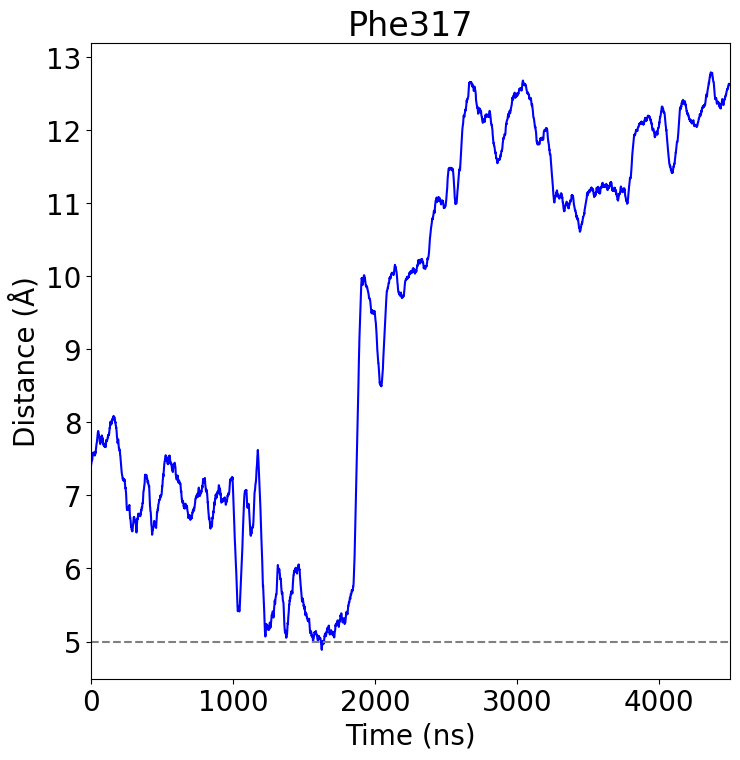

35 359 2 1093


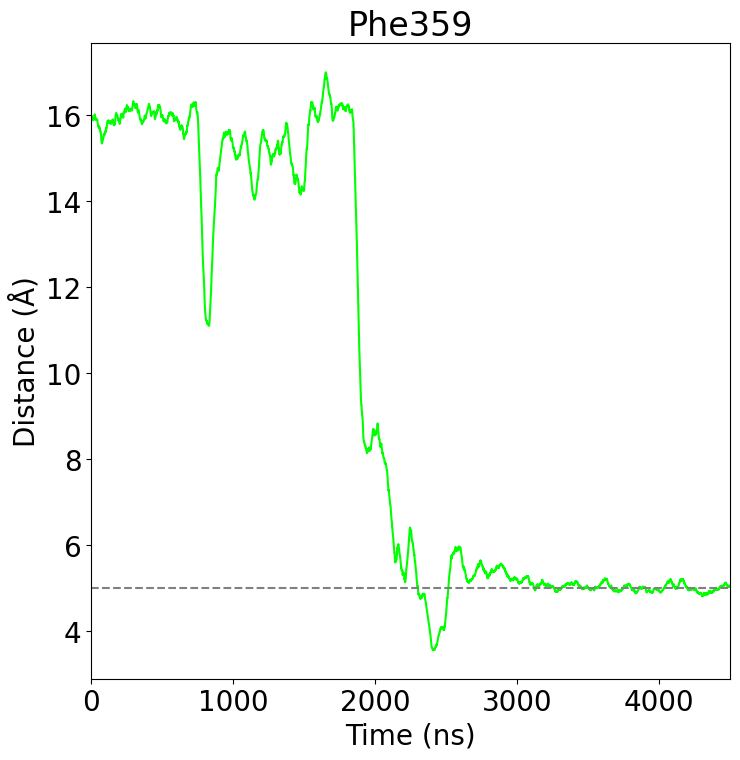

36 380 0 32


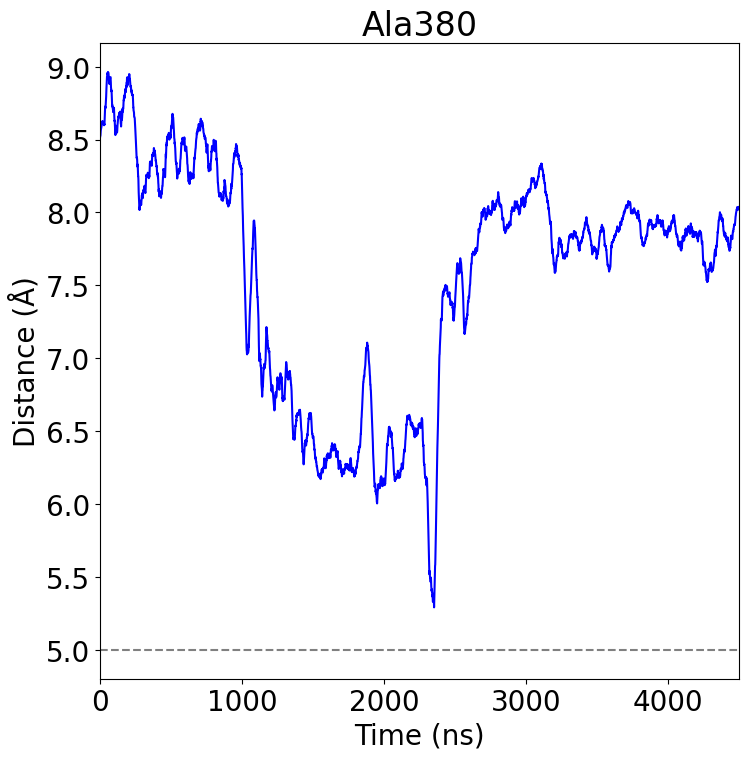

37 381 0 2583
38 381 1 1669
39 381 2 1539


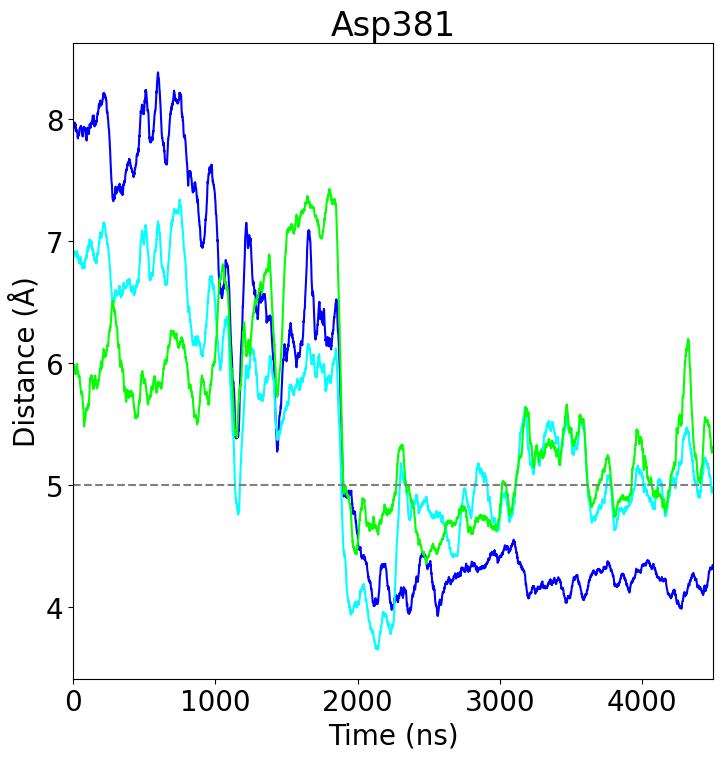

40 382 0 4419
41 382 1 2223
42 382 2 479


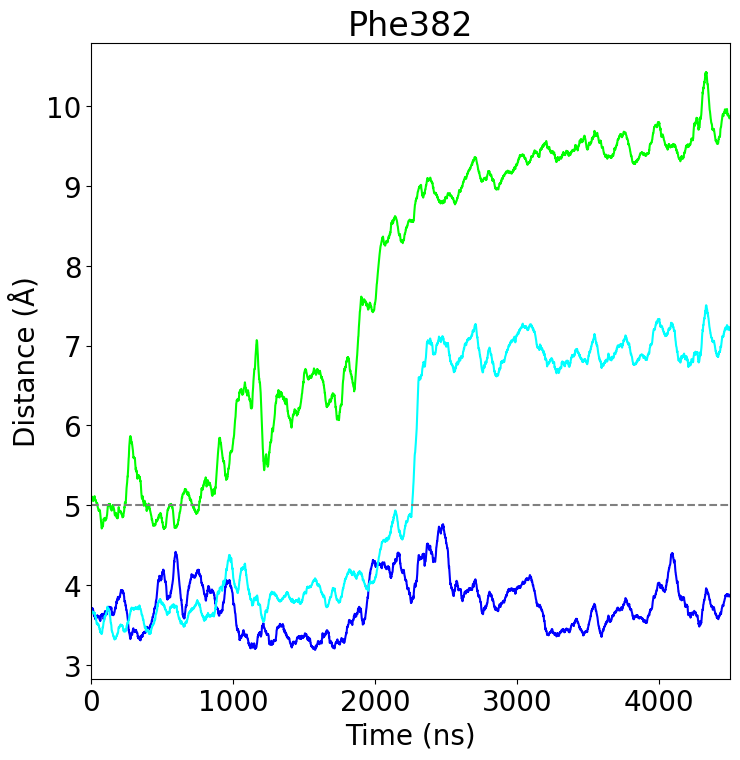

43 383 0 1538
44 383 1 475


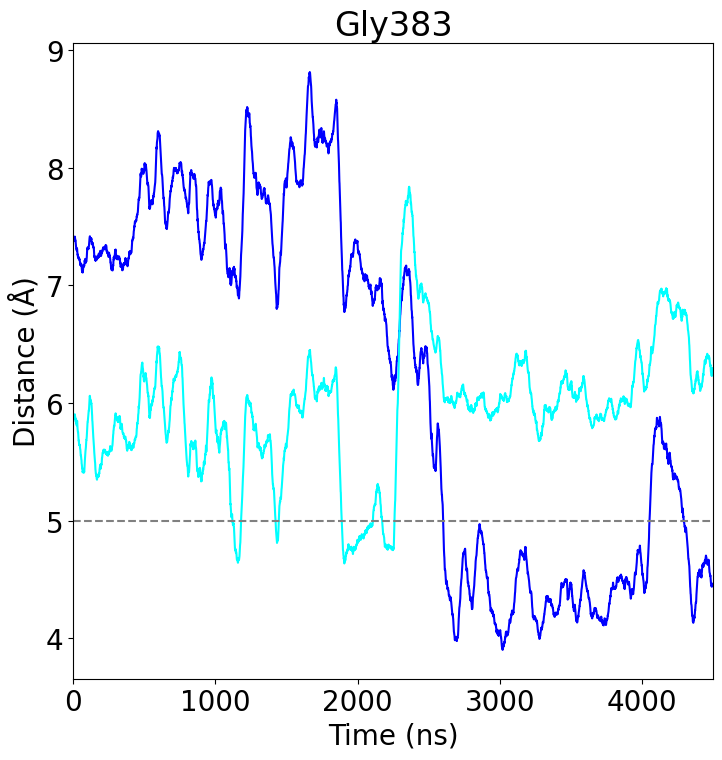

45 384 0 681
46 384 1 176


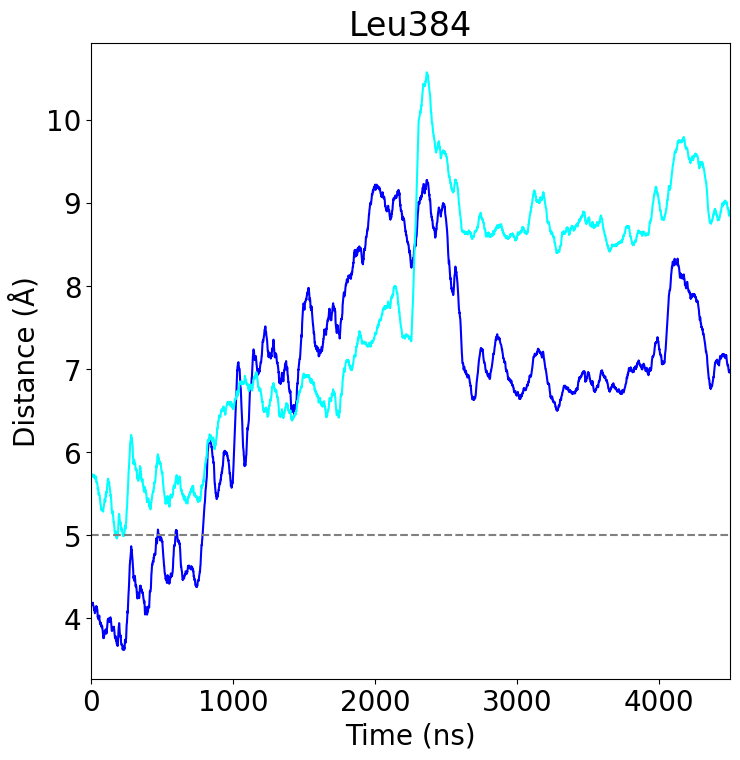

47 386 0 102
48 386 1 1538
49 386 2 1664


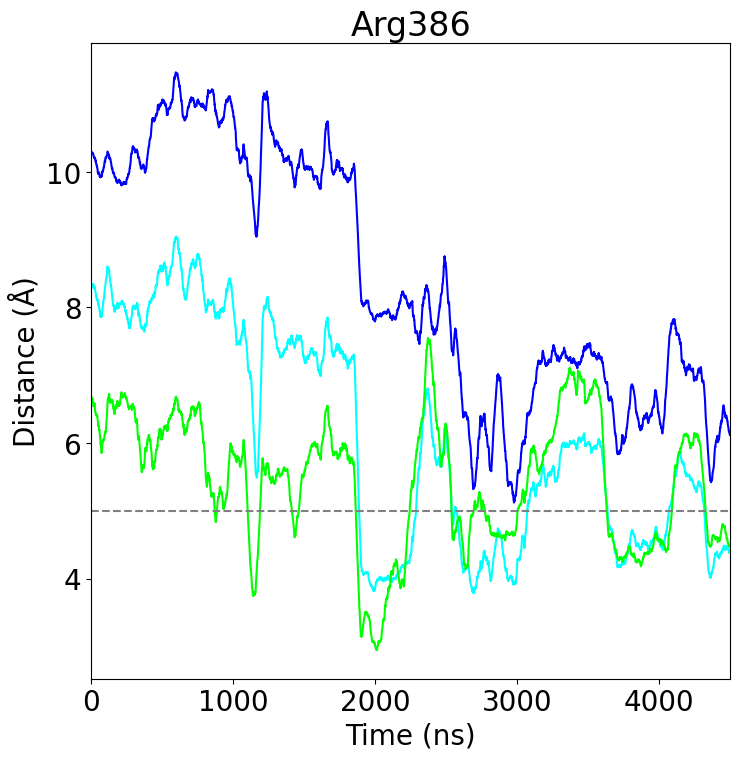

50 387 0 168
51 387 1 1483
52 387 2 1386


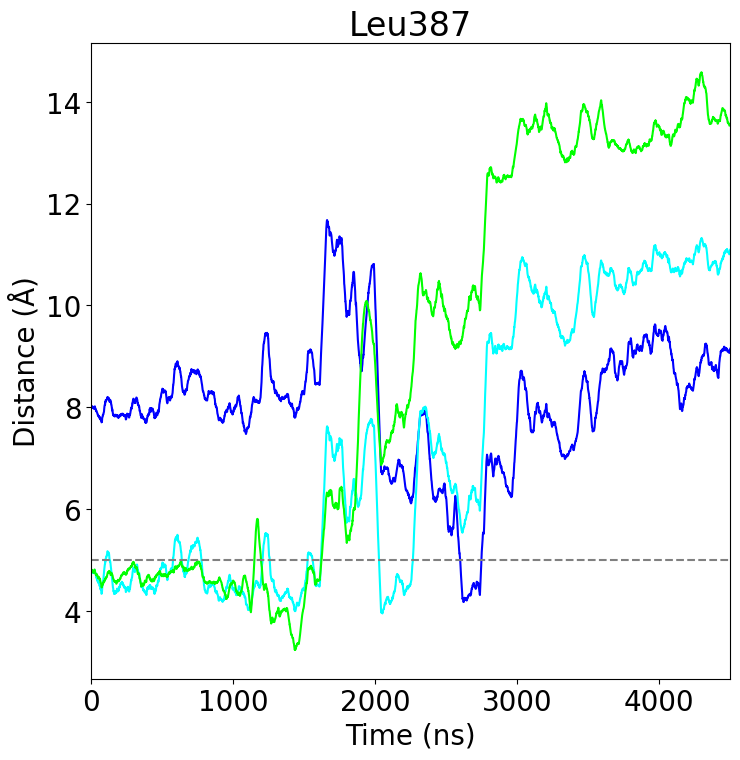

53 388 0 247
54 388 1 842
55 388 2 88


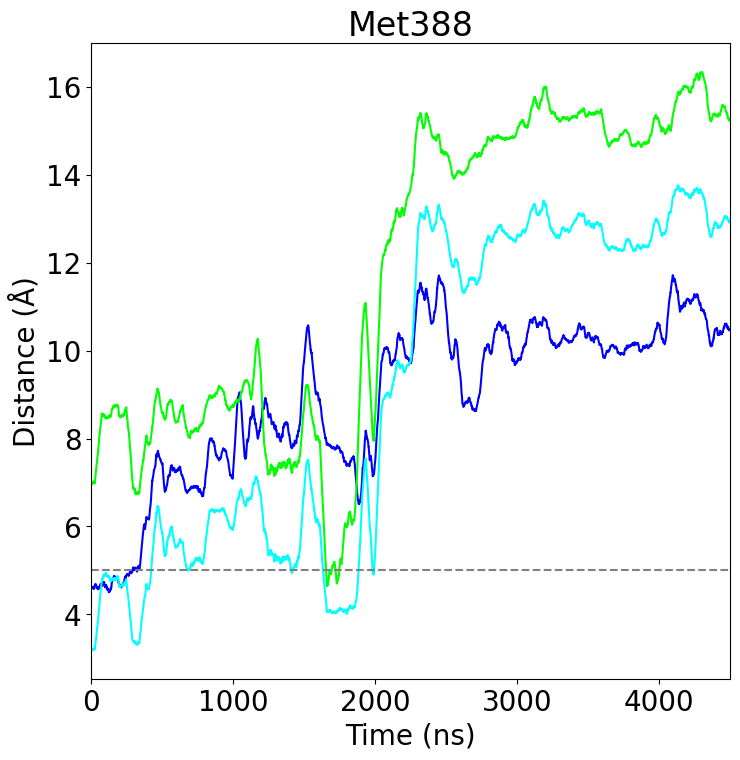

Number residue contacts: 55, Number contacting mult. frags: 18


In [12]:
'''
Constructs contact list from residues that contact the ligand by < 5 A in >100 frames
Plots smoothed featurization and appends contacts to contact_list
'''
contact_res = []
multicontact_res = []
contact_list = []
clist = ["blue","cyan","lime","orange","red"]
cv_num = 0
for i, residue in enumerate(featurized):
    n_frag = 0
    for j, frag in enumerate(residue):
        n_contacts = np.count_nonzero(frag < 5)
        if n_contacts > 20:
            cv_num += 1
            print(cv_num ,traj.topology.residue(i).resSeq, j, n_contacts)
            n_frag +=1
            contact_res.append(traj.topology.residue(i))
            contact_list.append([j,traj.topology.residue(i).resSeq])
            plt.plot(smooth_traj(featurized[i,j],50), color=clist[j])
    if n_frag > 0:
        plt.ylabel("Distance (Å)")
        plt.xlabel("Time (ns)")
        plt.title(str(traj.topology.residue(i)).title())
        plt.xlim(0,featurized.shape[2])
        plt.axhline(5, ls="--", color="gray")
        plt.show()
    
    if n_frag > 1:    
        multicontact_res.append(traj.topology.residue(i))

print("Number residue contacts: {}, Number contacting mult. frags: {}".format(len(contact_res), len(multicontact_res)))

In [13]:
len(contact_list)

55

In [14]:
# Create nested dictionary CV_info[i]->{a: [group1], b: [group2], traj:[centers*numImgs]}
CV_info = {}

# Populate dictionary from contact list
for frag,resid in contact_list:
    residue_atoms = traj.topology.select("resSeq "+str(resid)+" and protein and not element He")
    append_CV_dict(CV_info, imat_frags[frag], residue_atoms)
        
# add any additional CVs
append_CV_dict(CV_info, residue_271, residue_286)
# append_CV_dict(CV_info, residue_286, residue_386)

Calculate colvar values during SMD trajectory
----
Calculate CV values at every frame

In [15]:
def group_dist(traj, group1, group2):
    '''Calculates COM of each group then calculates distance between COMs'''
    group1_com = md.compute_center_of_mass(traj.atom_slice(group1))
    group2_com = md.compute_center_of_mass(traj.atom_slice(group2))
    group_dist = np.linalg.norm(group1_com-group2_com, axis=1)*10
    return group_dist
    

In [16]:
def calc_CV_dist(frames=None, CV_info=None, stride=1):
    '''Calculates distance in CV space between frames of a trajectory
    returns distances as 1d array of length len(frames)-1'''
    # Get all frames if none selected
    if not frames:
        frames = range(len(CV_info[list(CV_info.keys())[0]]['CV_points']))
    
    CV_points = np.asarray([CV_info[i]['CV_points'] for i in CV_info])[:,frames]
    CV_dists = np.linalg.norm(CV_points[:,stride:]-CV_points[:,:-stride], axis=0)
    return CV_dists
    

In [17]:
# Populate CV_info with trajectories of CV values
for key in CV_info:
    CV_info[key]['CV_points'] = group_dist(traj, CV_info[key]['a'], CV_info[key]['b'])

In [18]:
# Smooth out CV trajectories with a running average
for key in CV_info.keys():
    CV_traj = CV_info[key]['CV_points']
    CV_info[key]['CV_points'] = smooth_traj(CV_traj,50)

In [23]:
'''
start_frame, end_frame, stride: Adjust to use subset of pull trajectory
max_step: Maximum number of frames between images
dist: Target value for distance between images, tweak until desired number of images achieved 
'''

start_frame = 0
end_frame = len(traj)
stride = 1
max_step = 1700
dist = 4.1


sel_frames = [0]
step = 0
prev_frame = 0
for i in range(1,end_frame,stride):
    step += stride
    CV_dist = calc_CV_dist([prev_frame,i], CV_info=CV_info)
    if CV_dist > dist or step > max_step:
        print(i,CV_dist[0])
        sel_frames.append(i)
        prev_frame = i
        step = 0
print(len(sel_frames))

786 4.149124417994068
1013 4.269194852775388
1129 4.184243108219491
1202 4.189930236276322
1406 4.1134506202731265
1495 4.15033789475725
1630 4.213091990182177
1791 4.1219033600446515
1856 4.125625134628342
1868 4.109685710901604
1879 4.172377846278588
1891 4.213879467804551
1917 4.122958942874858
1959 4.180481961147449
2030 4.113259176656721
2087 4.134791392441343
2250 4.125928876132921
2280 4.244095685106325
2302 4.304556606660349
2371 4.1442517689577745
2415 4.106168670219452
2512 4.2200976042499025
2605 4.165223555919909
2777 4.153779904687689
3112 4.123652443116395
3361 4.108196814716869
3671 4.102773628848746
4086 4.146944836381972
4295 4.1372473719788845
4362 4.138628760199298
31


In [24]:
# Adjust sel_frames if needed
sel_frames = sel_frames+[traj.n_frames-1]
print(len(sel_frames))
print(sel_frames)

32
[0, 786, 1013, 1129, 1202, 1406, 1495, 1630, 1791, 1856, 1868, 1879, 1891, 1917, 1959, 2030, 2087, 2250, 2280, 2302, 2371, 2415, 2512, 2605, 2777, 3112, 3361, 3671, 4086, 4295, 4362, 4499]


## Extra Analysis Stuff

<IPython.core.display.Javascript object>


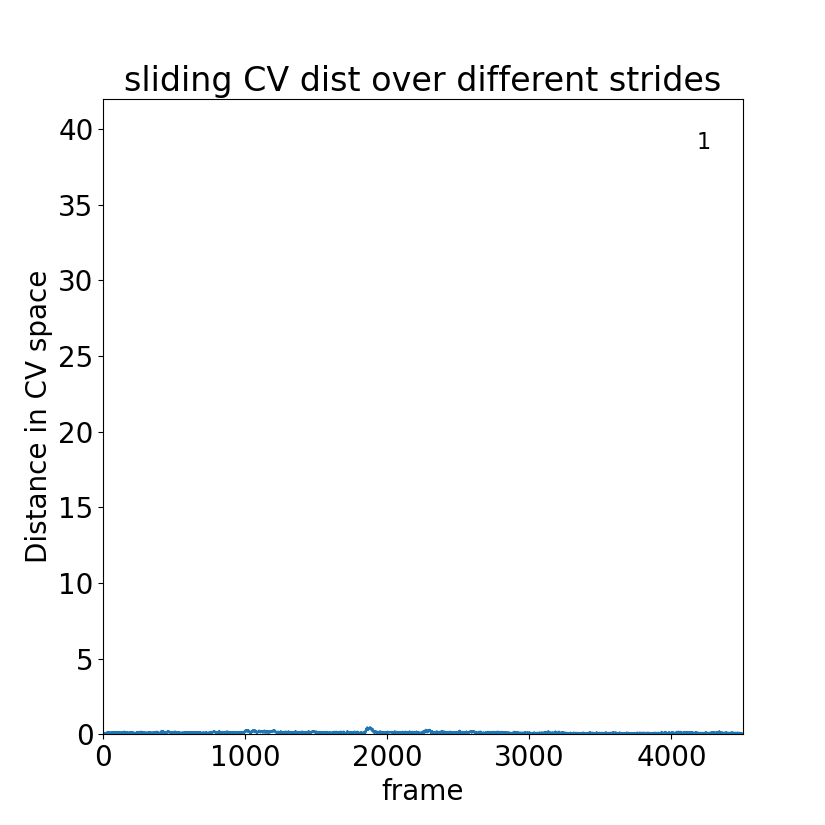

interactive(children=(IntSlider(value=1, description='i', layout=Layout(width='500px'), max=4500, min=1), Outp…

<function __main__.update(i)>

In [25]:
%matplotlib notebook
#re-enable `%matplotlib inline` after use

for_plot = calc_CV_dist(range(0, traj.n_frames), CV_info=CV_info, stride=traj.n_frames-1)
x_vals = range(len(for_plot))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.set_xlim(0,traj.n_frames)
ax.set_ylim(0,np.amax(for_plot))
graph, = ax.plot(x_vals,for_plot)
plt.title("sliding CV dist over different strides")
ax.set_xlabel("frame")
ax.set_ylabel("Distance in CV space")
stride_text = ax.text(0.95,0.95,str(1),transform=ax.transAxes, size=16, ha='right', va='top')

def update(i):
    for_plot = calc_CV_dist(range(0, len(traj)), CV_info=CV_info, stride=i)
    x_vals = range(len(for_plot))
    graph.set_data(x_vals, for_plot)
    stride_text.set_text(i)
    
interact(update, i=widgets.IntSlider(min=1,max=traj.n_frames,step=1,value=1,layout=widgets.Layout(width='500px')))


In [26]:
#Revert to normal plotting mode
%matplotlib inline

Text(0.5, 1.0, 'CV dist from frame 0')

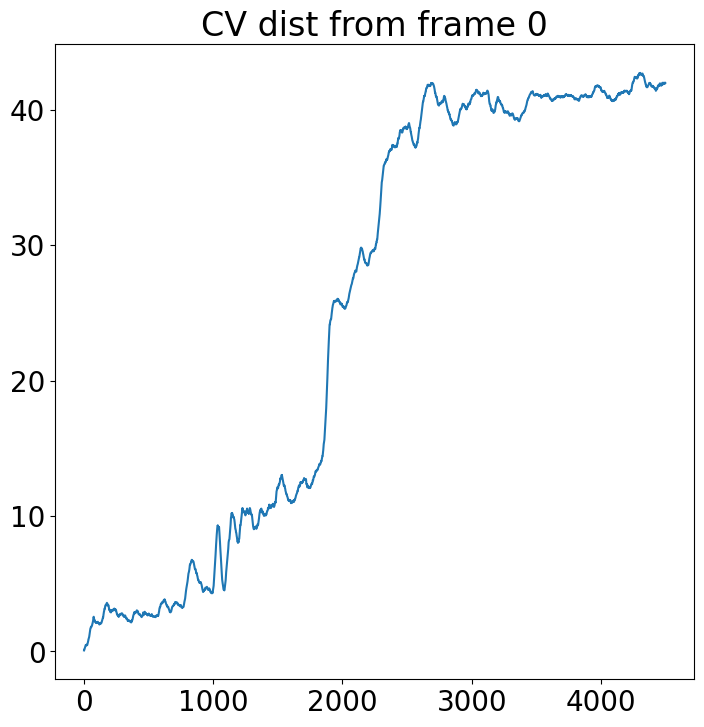

In [27]:
# calculate CV dist of each frame from initial frame
dist_from_init = []
for i in range(len(traj))[1:]:
    dist_from_init.append(calc_CV_dist([0,i], CV_info=CV_info)[0])

fig = plt.figure()
plt.plot(dist_from_init)
plt.title("CV dist from frame 0")

## Investigate selected frames

In [28]:
# Load selected frames
string_traj = traj[sel_frames]

In [29]:
# Adds arrays of "centers" to CV dictionary
for key in CV_info:
    CV_info[key]["traj"] = group_dist(string_traj, CV_info[key]['a'], CV_info[key]['b'])

In [30]:
# Check distances between images
# Note that these are no longer smoothed
data = np.zeros((len(sel_frames),len(CV_info)))
for i in range(data.shape[0]):
    for c in range(data.shape[1]):
        data[i,c] = CV_info[str(c+1)]["traj"][i]
for i in range(len(data)-1):
    print(np.linalg.norm(data[i+1]-data[i]))

7.258292606594265
3.8713695566534656
8.459006692863234
6.87994756354329
6.6153525026508575
9.077404816900307
5.978615784146083
6.720182181113867
5.11311254035255
5.742113027887975
11.740457579107174
7.811153758016295
6.884750662775517
6.681423600563889
7.967258172995646
5.807446810658006
4.076510992583686
10.173294566782026
7.312865069724299
7.239658532914581
5.413791735337374
4.974594899669684
6.544930547961337
7.471445130489409
5.82570827577641
5.87645052745524
4.851573705397139
5.699534835502163
5.683134989145177
5.803675756421903
4.297382308015179


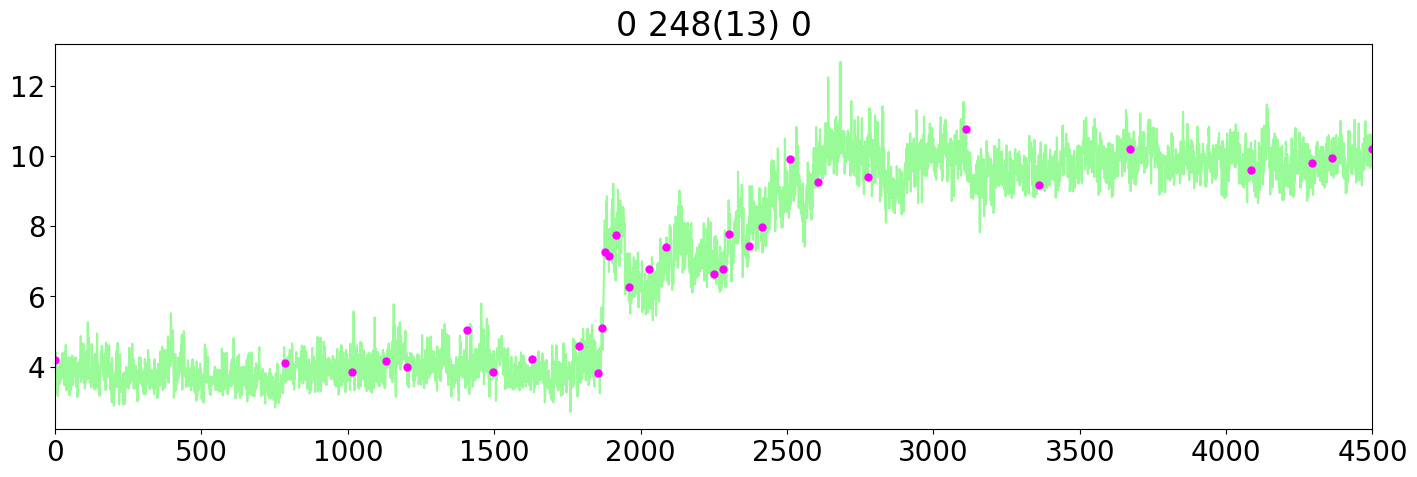

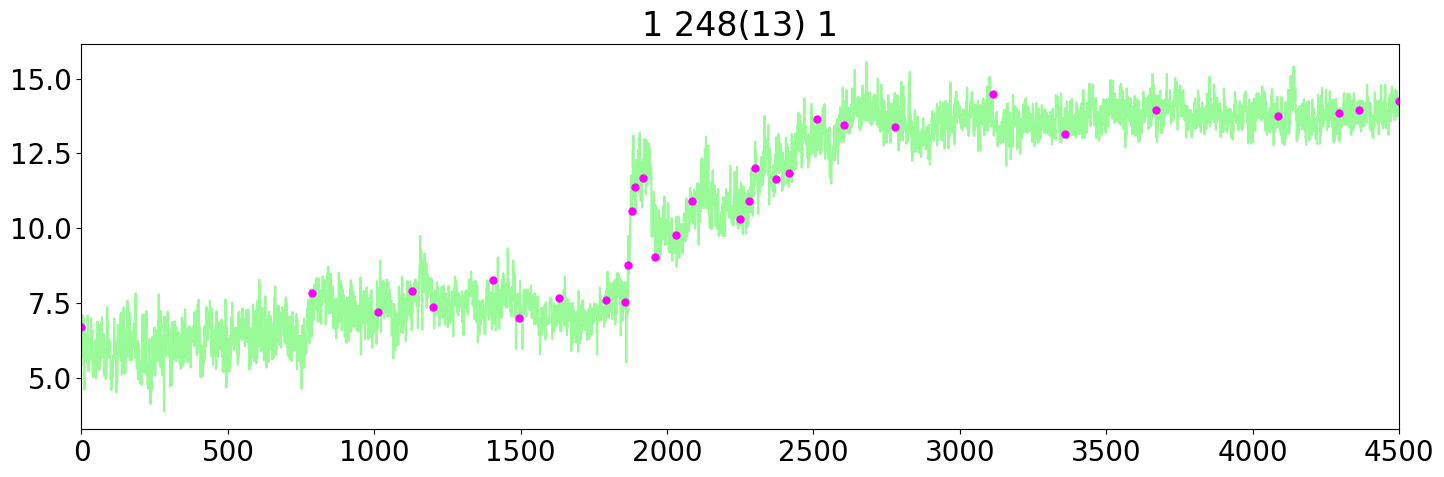

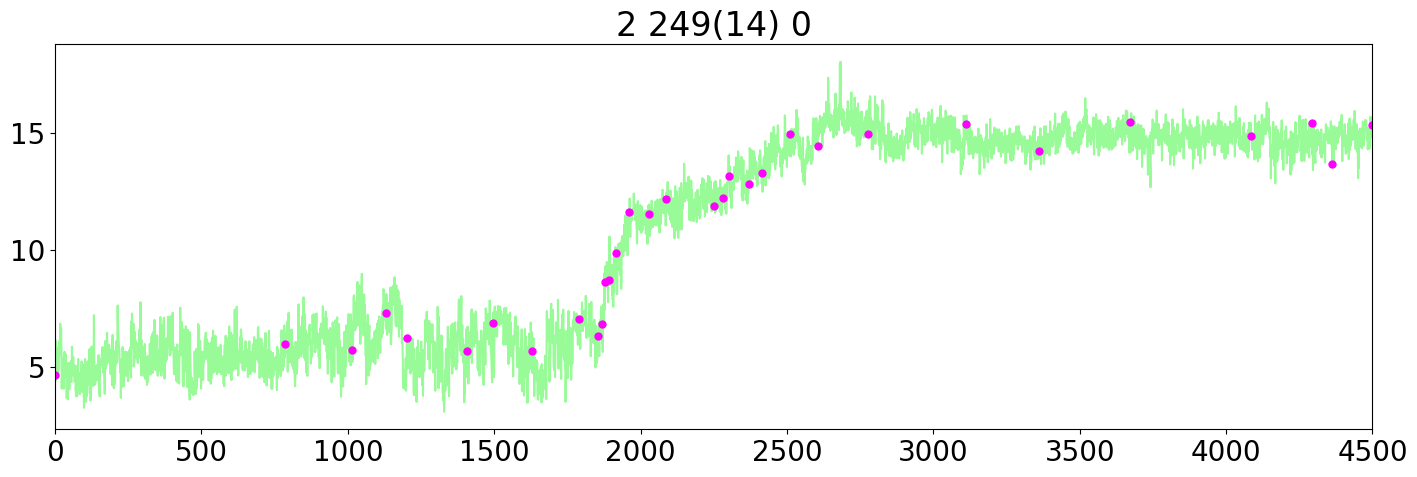

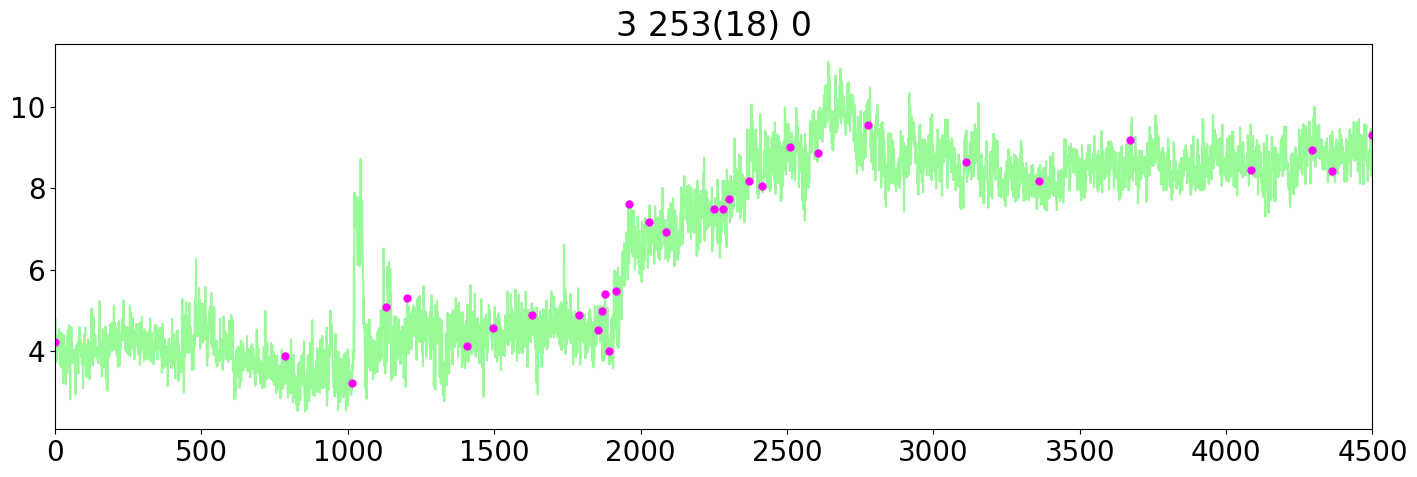

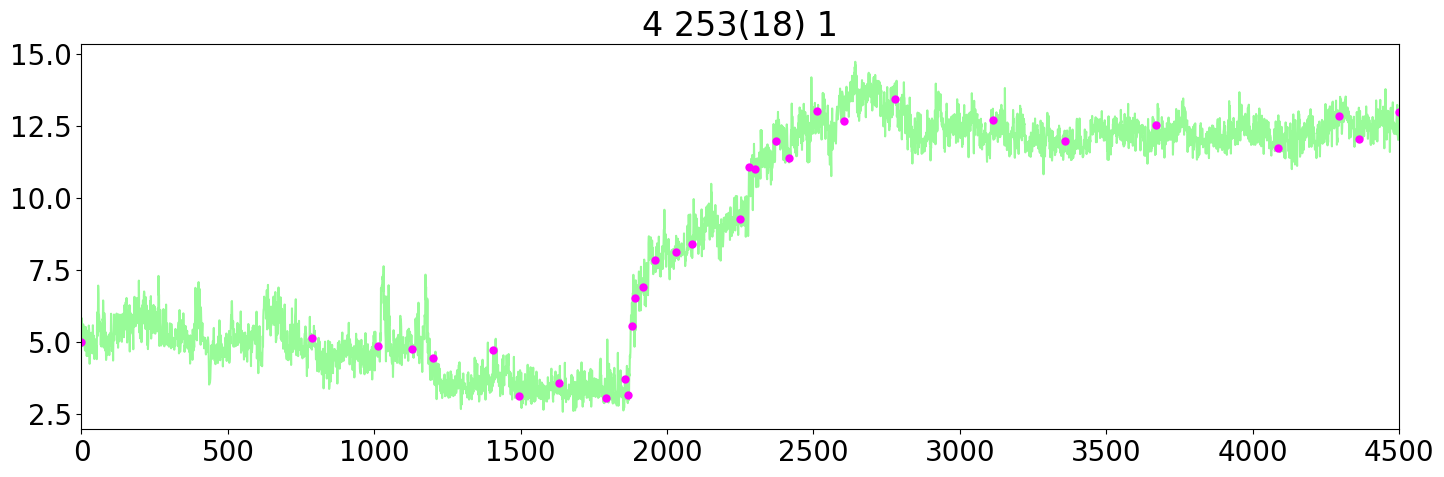

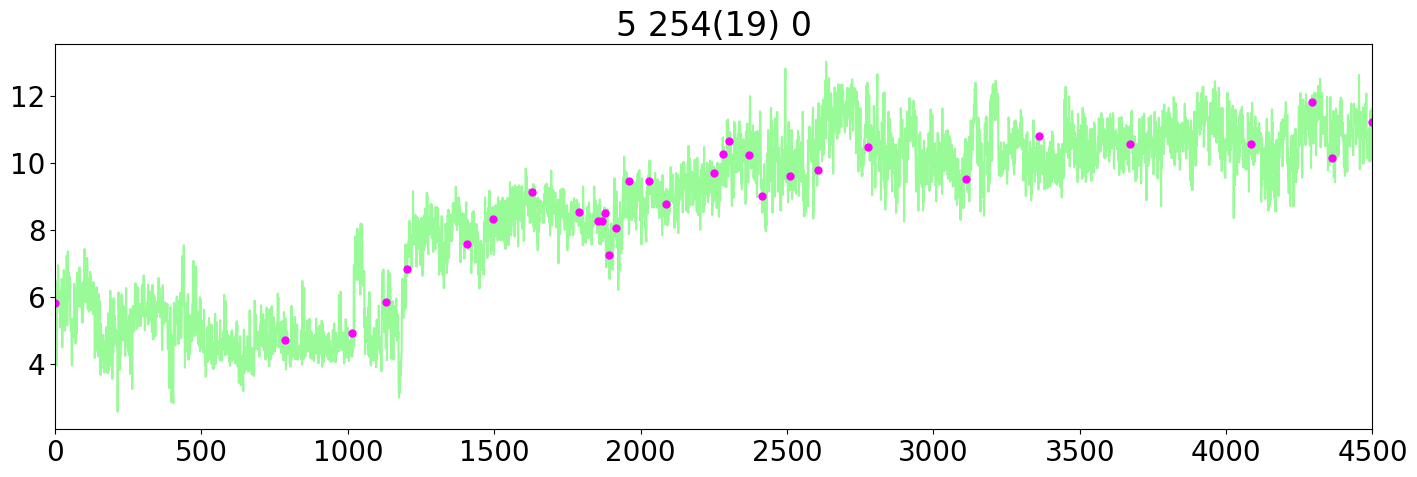

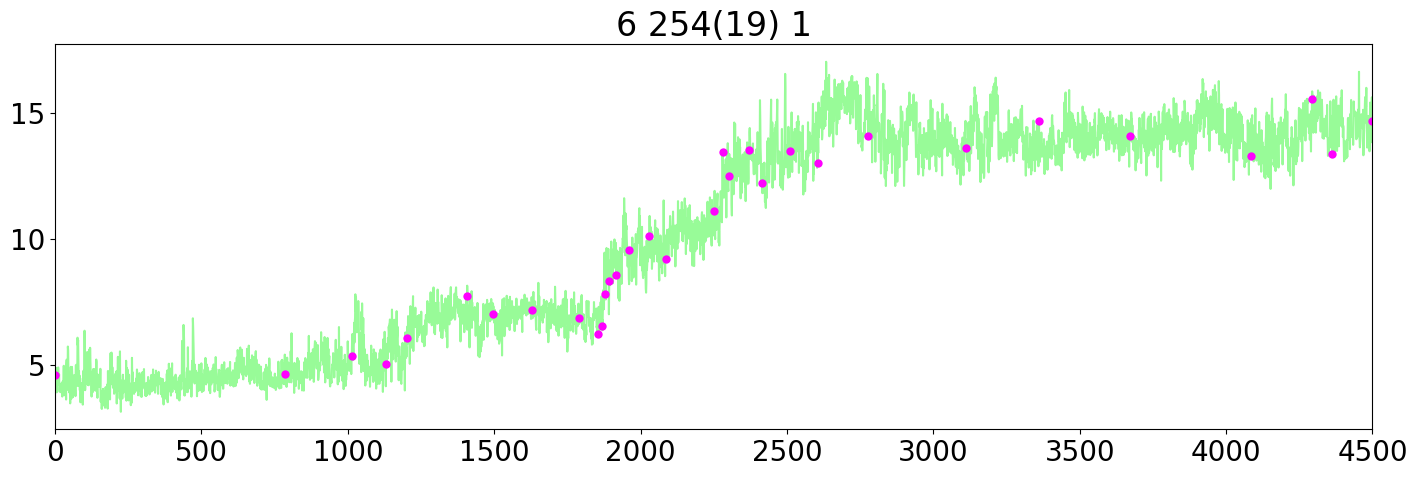

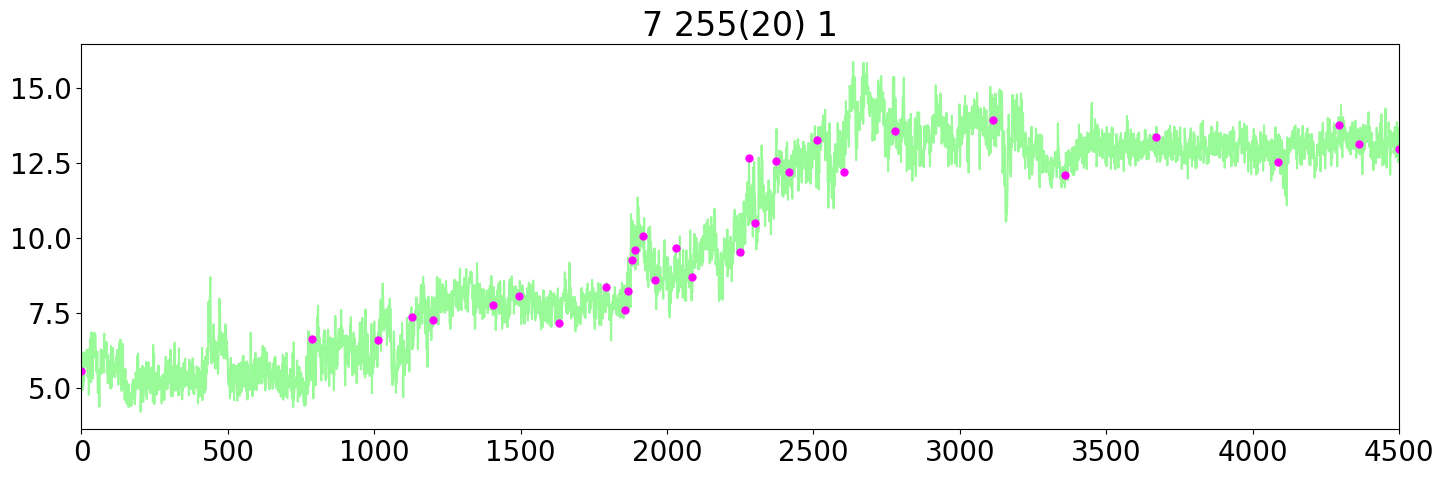

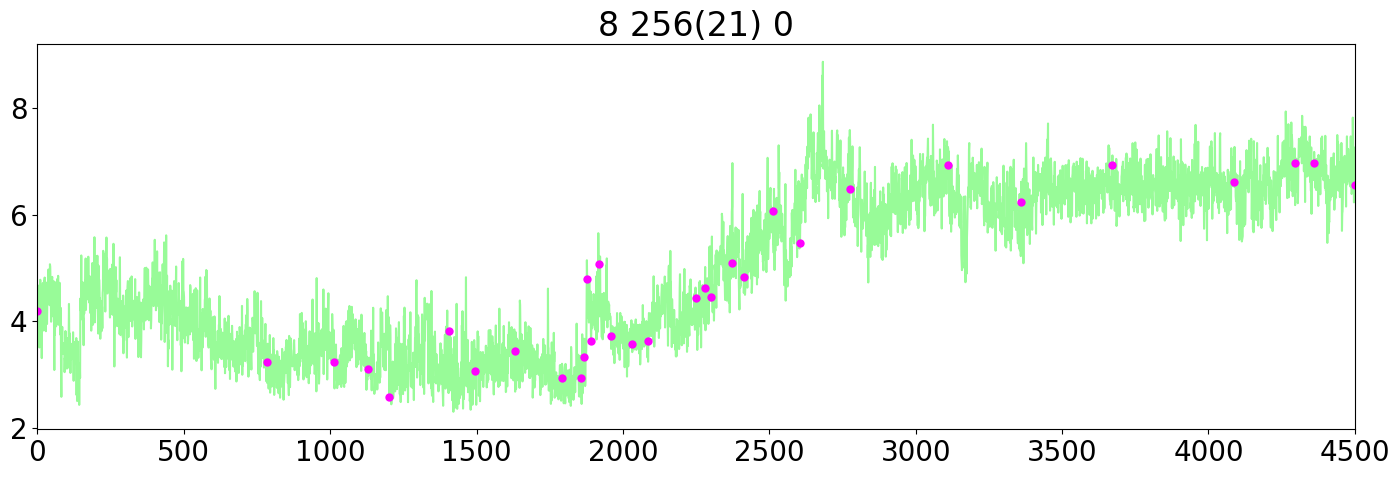

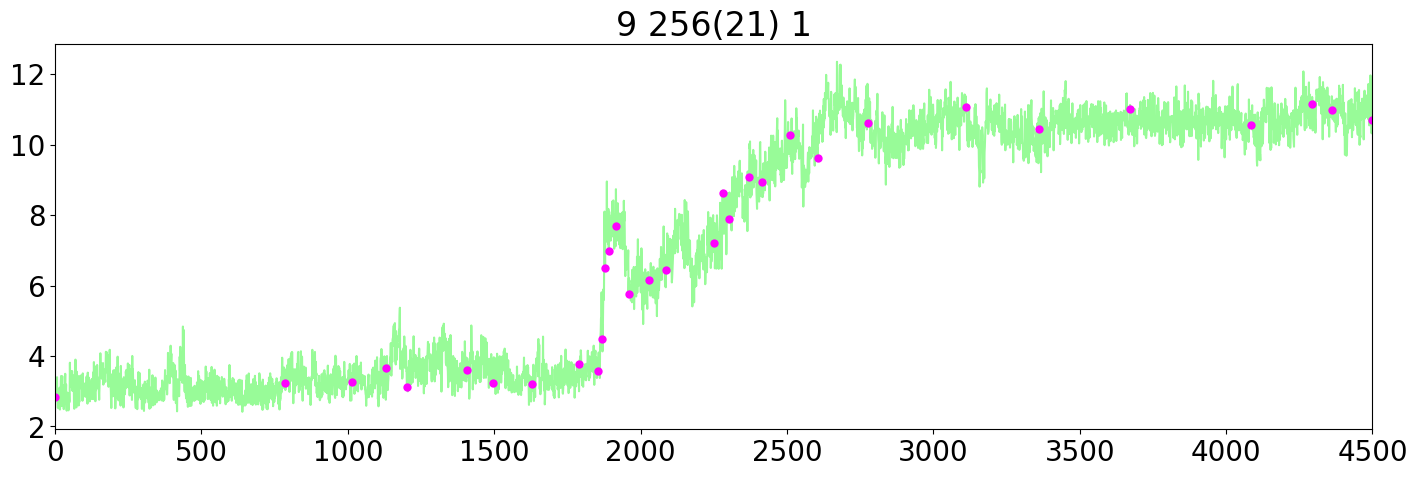

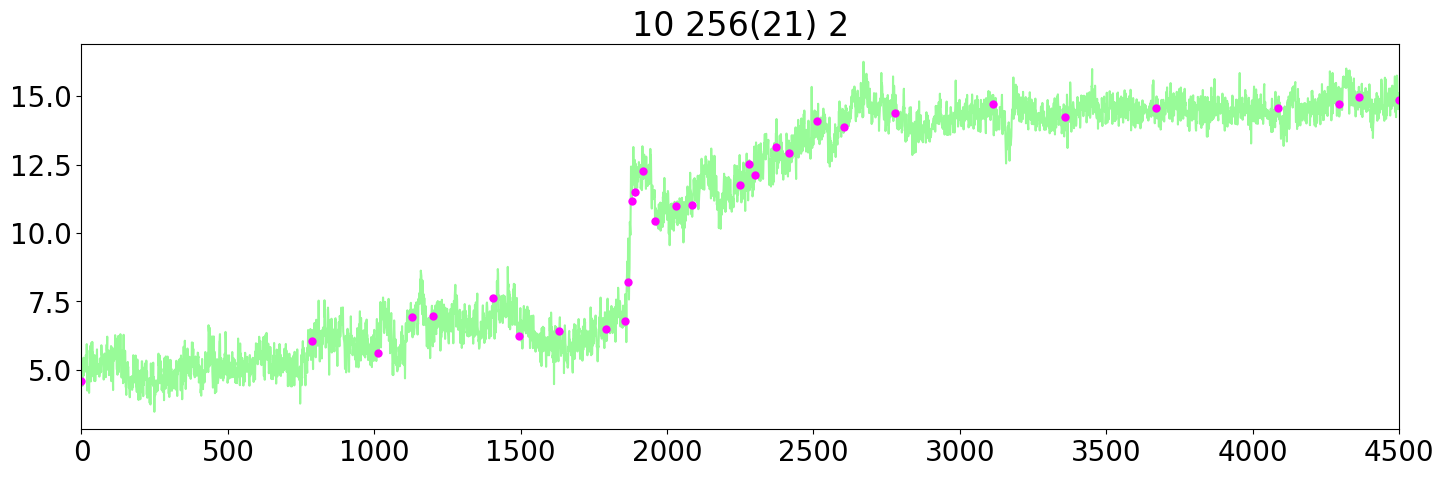

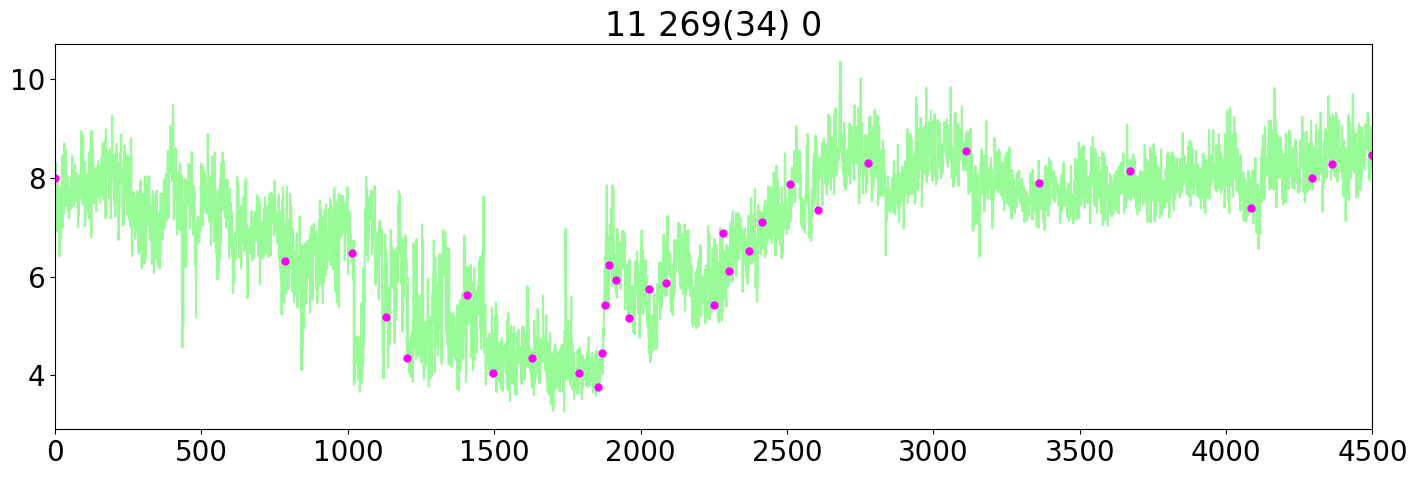

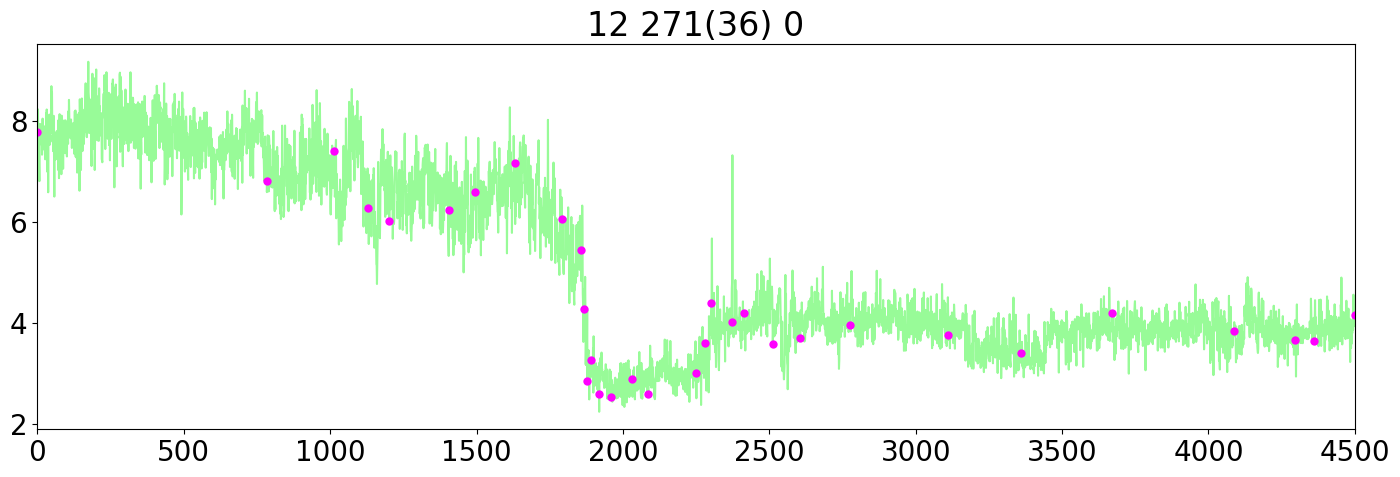

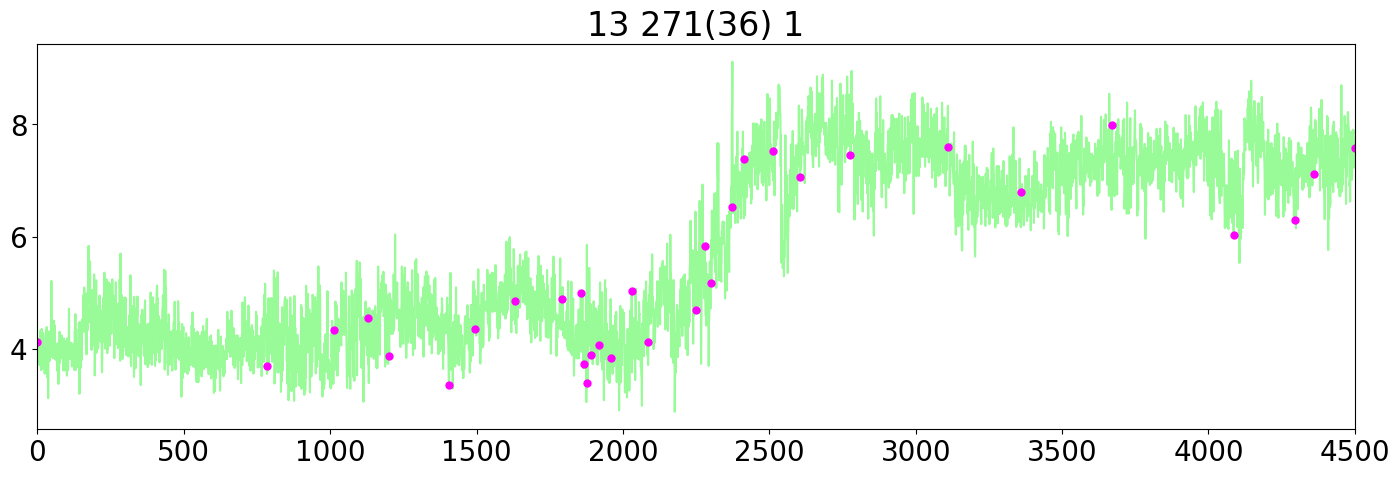

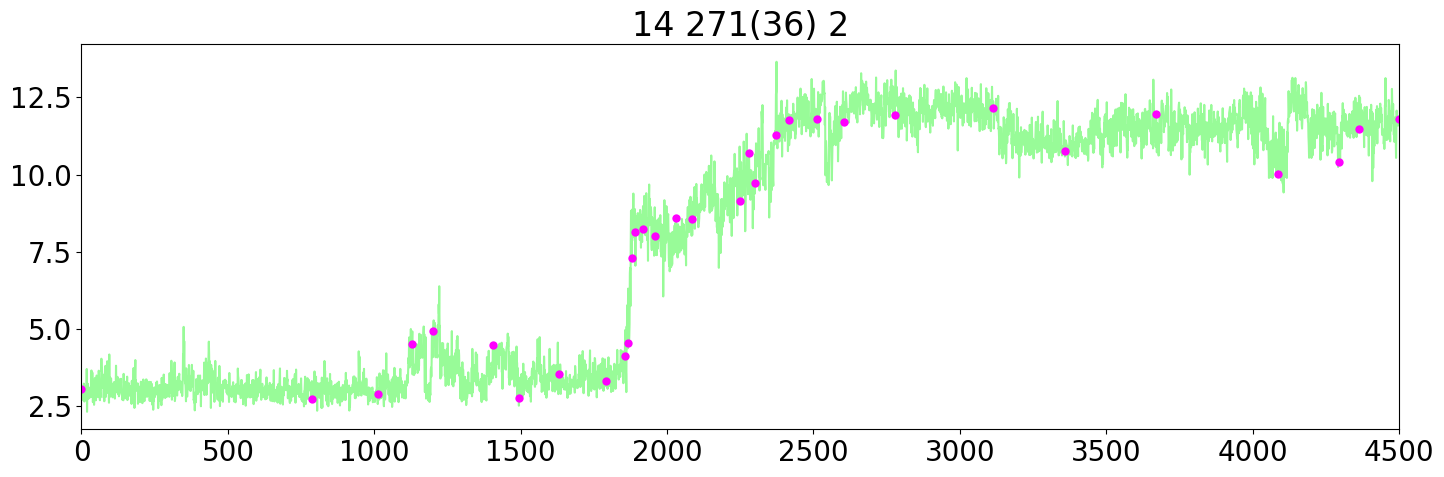

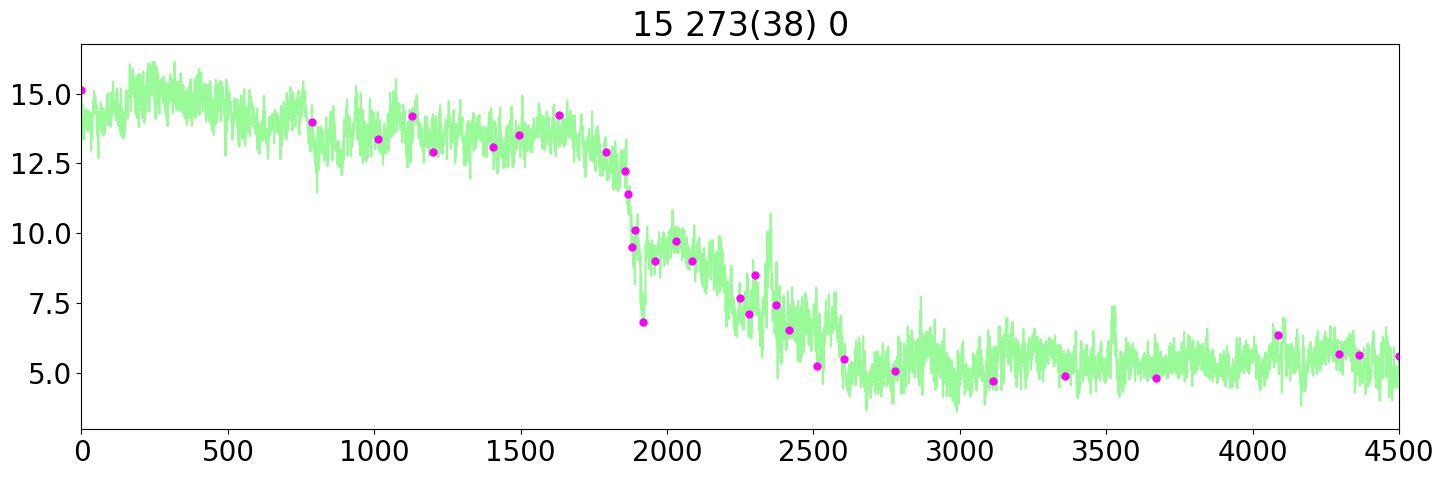

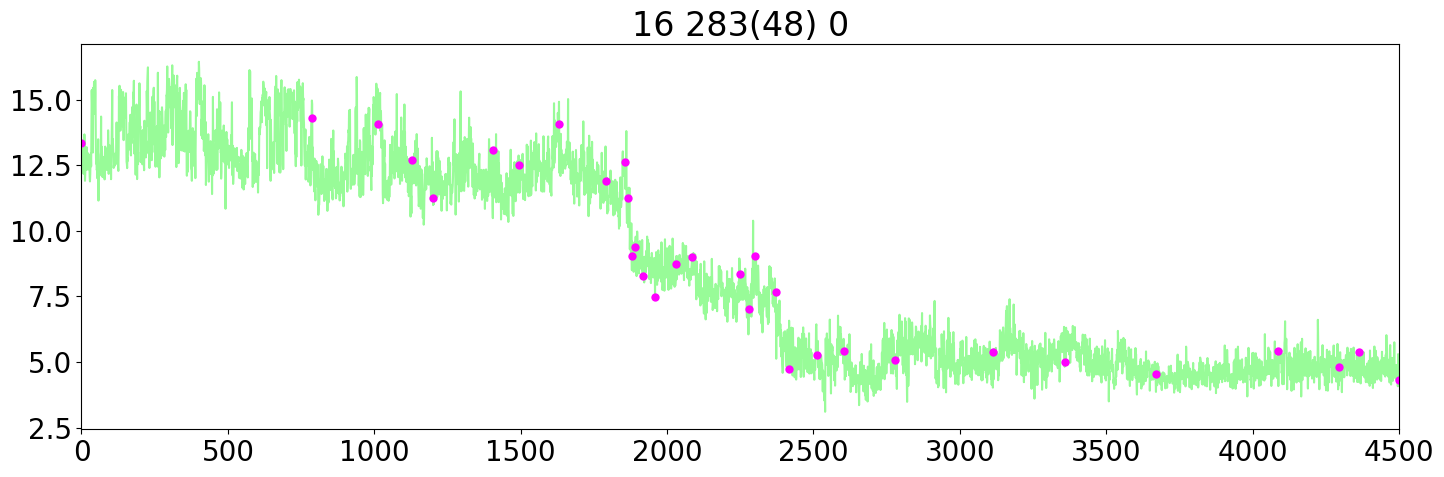

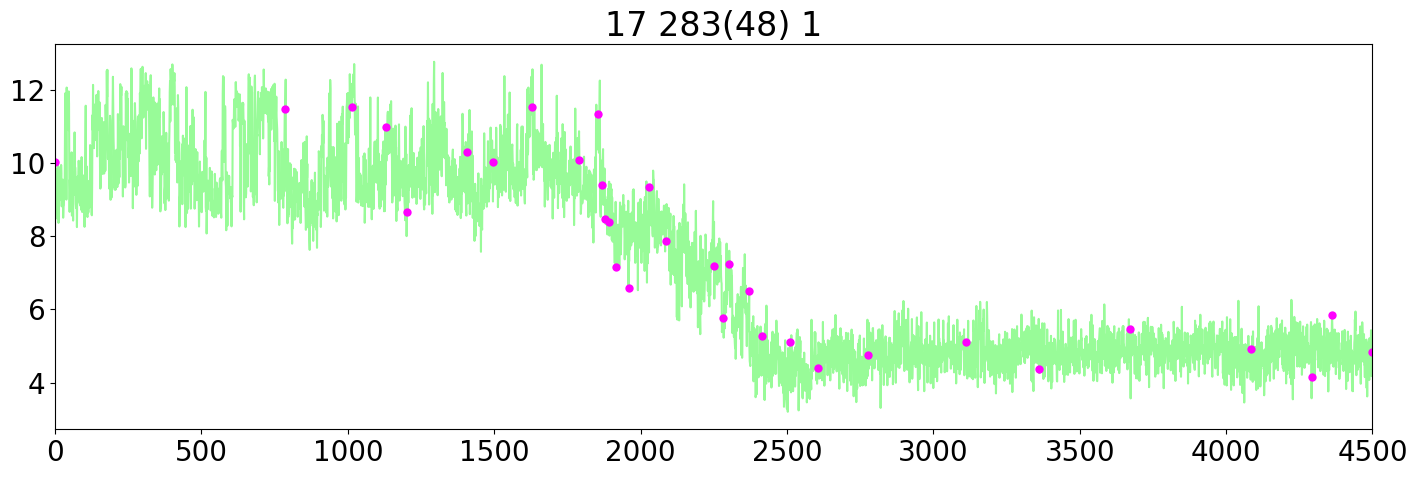

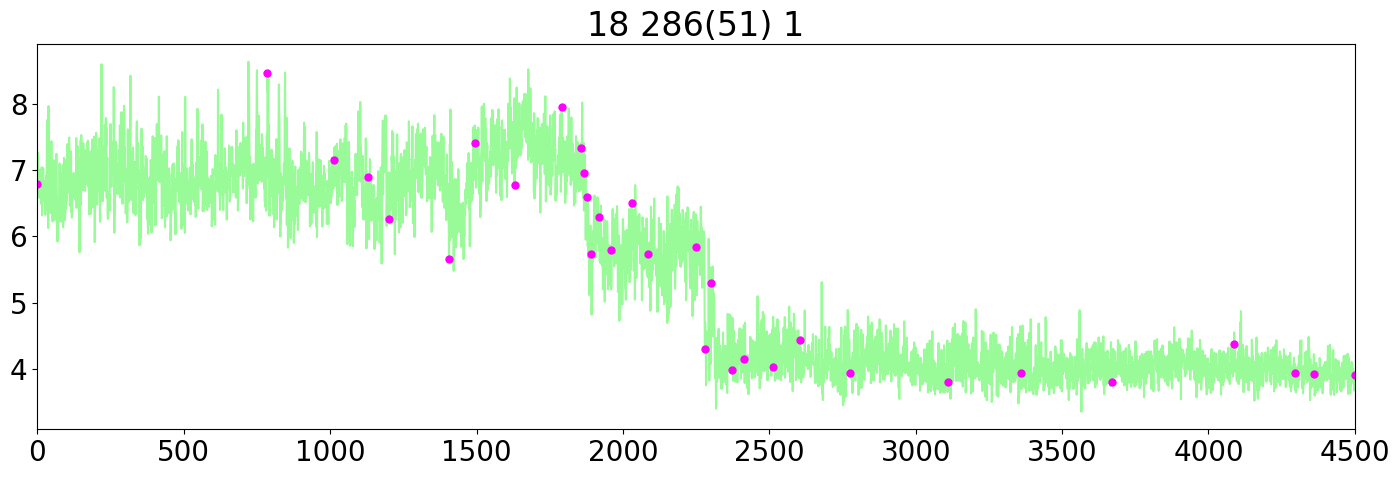

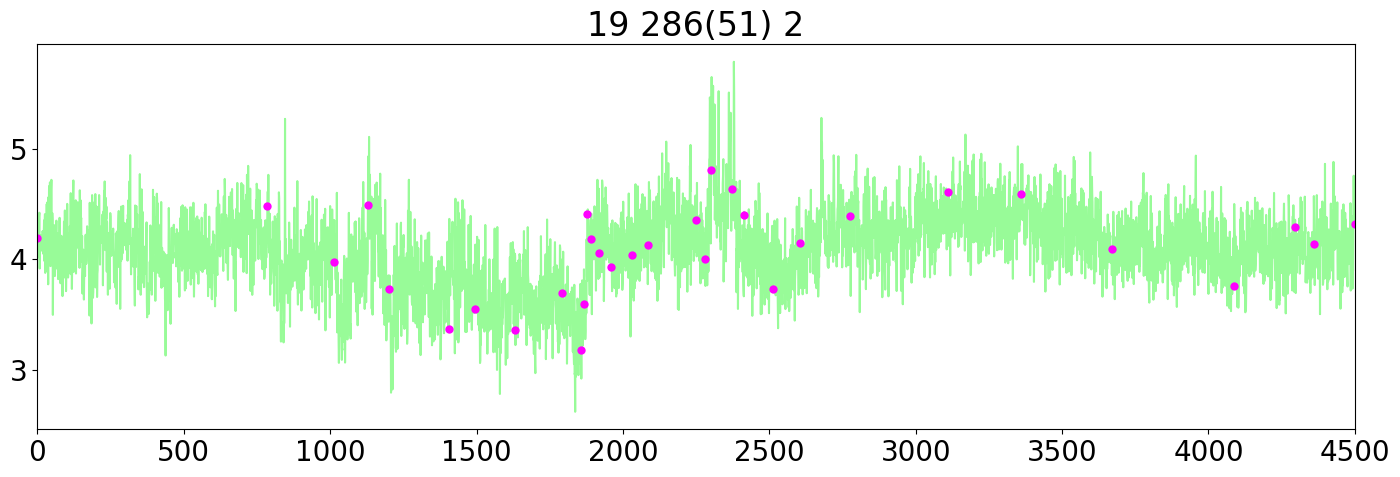

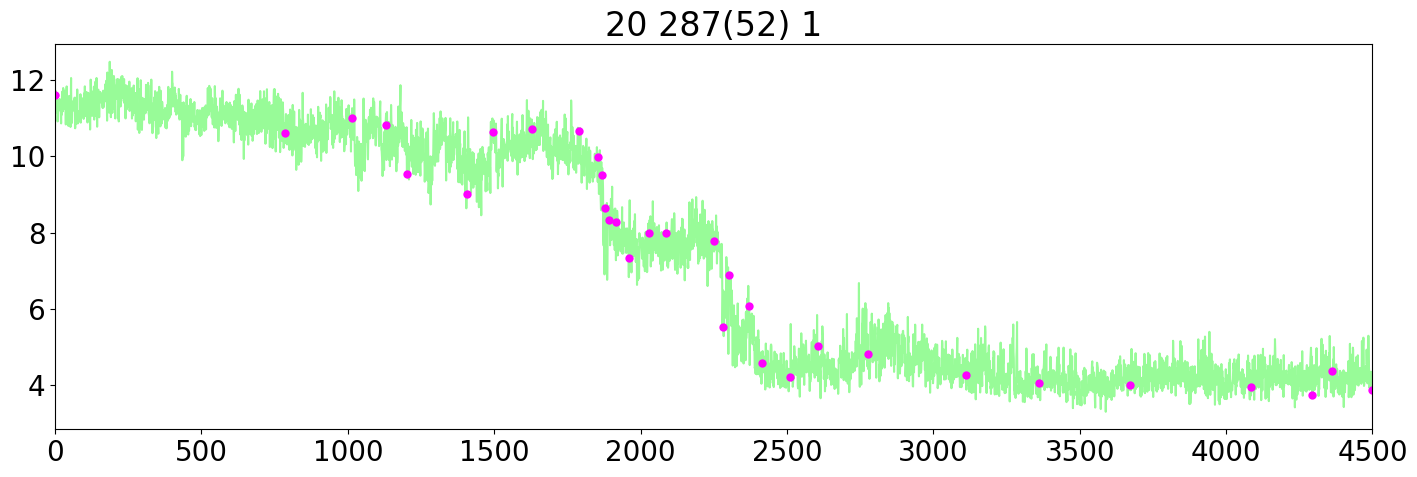

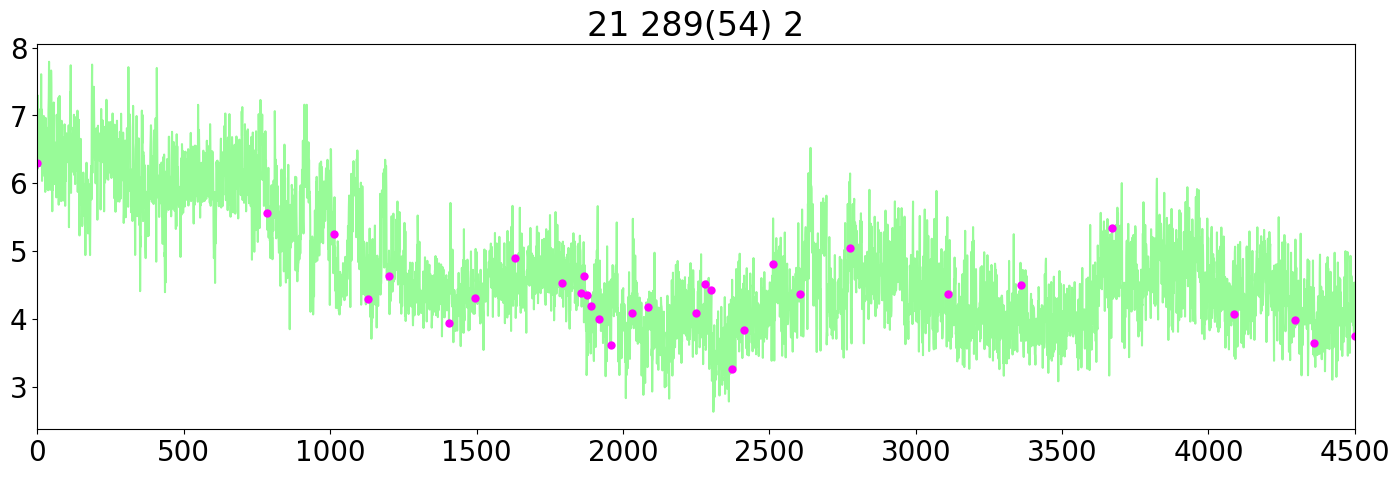

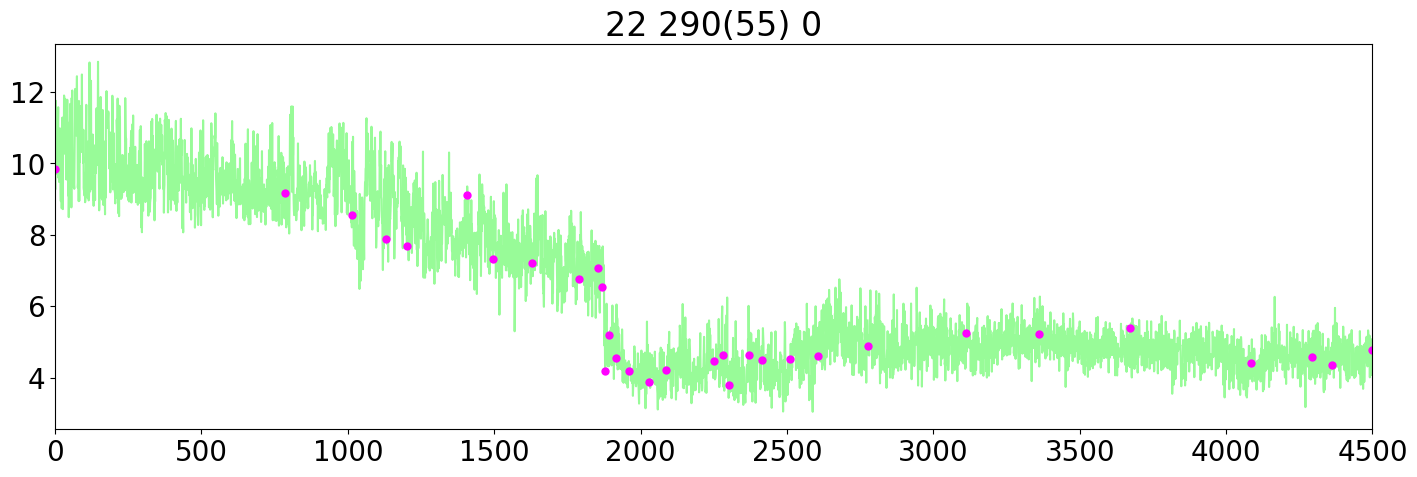

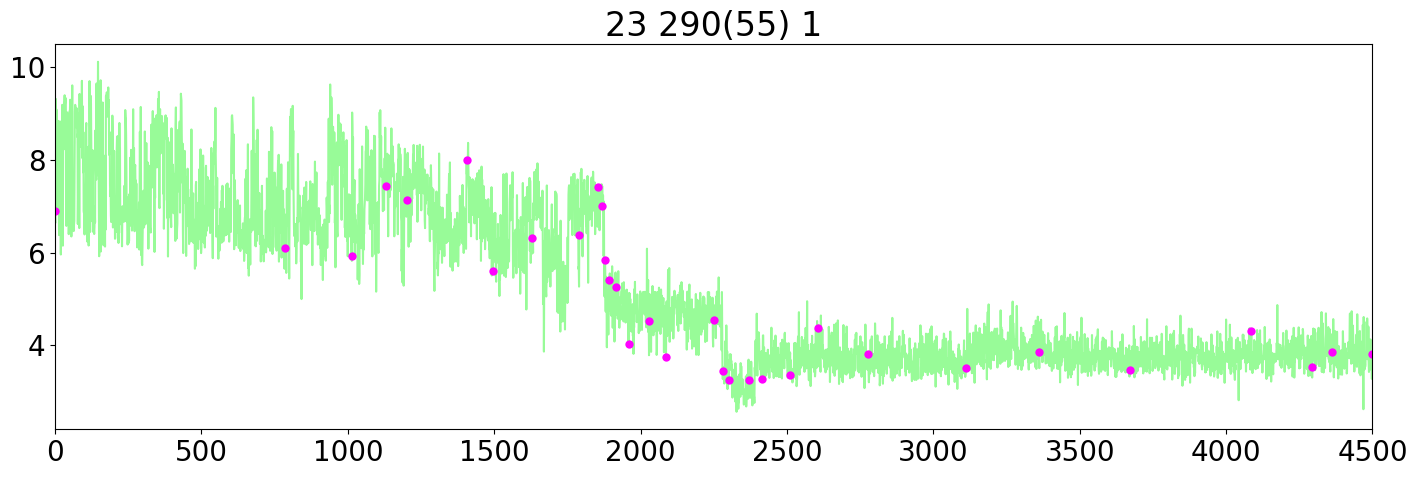

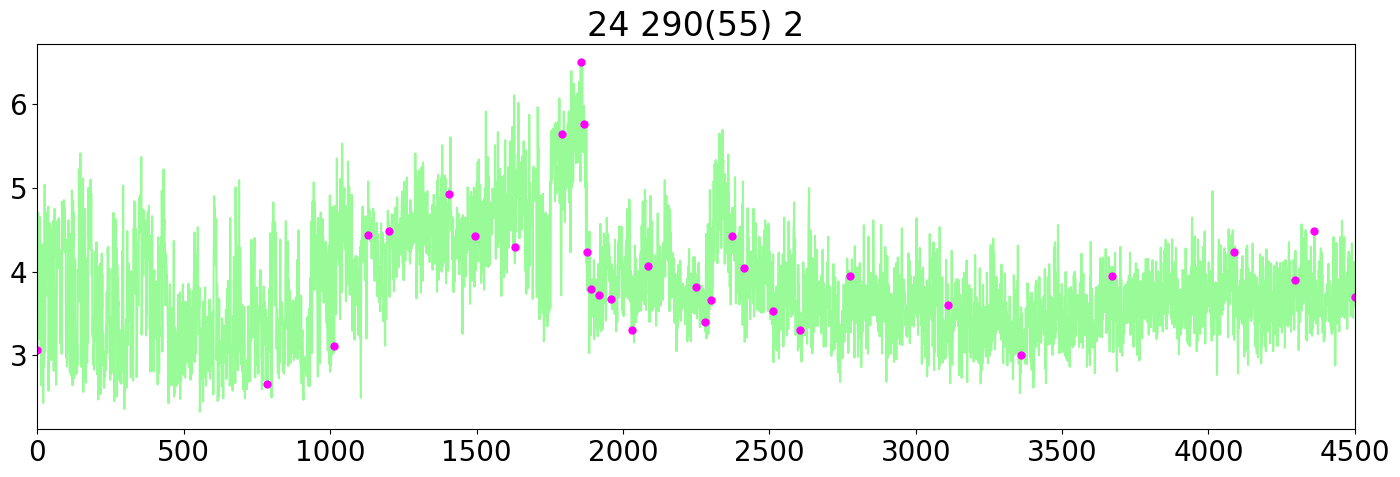

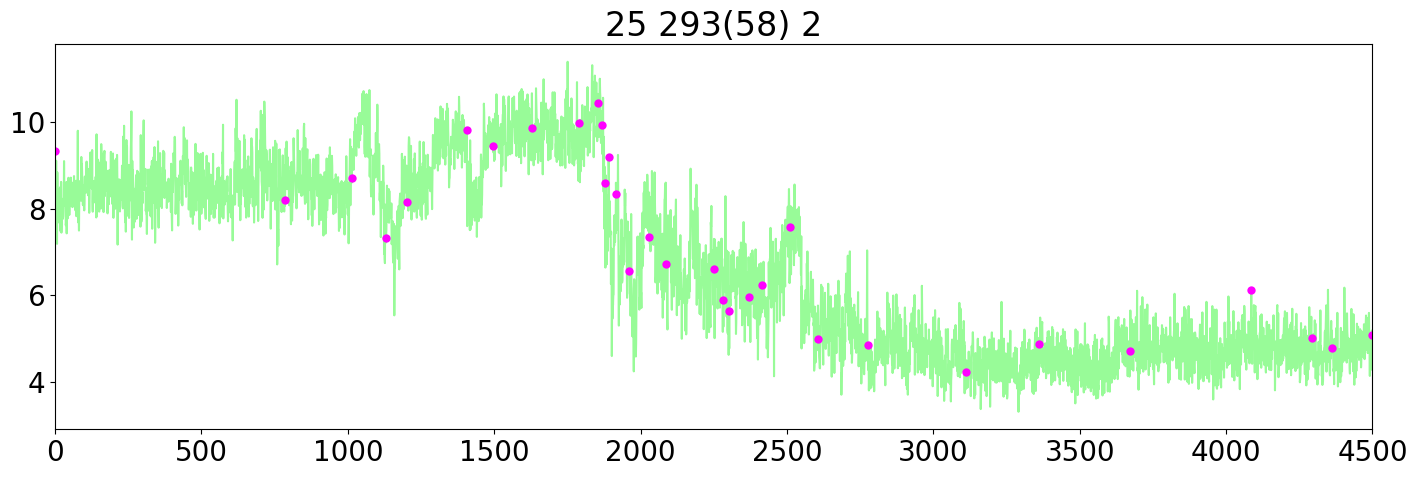

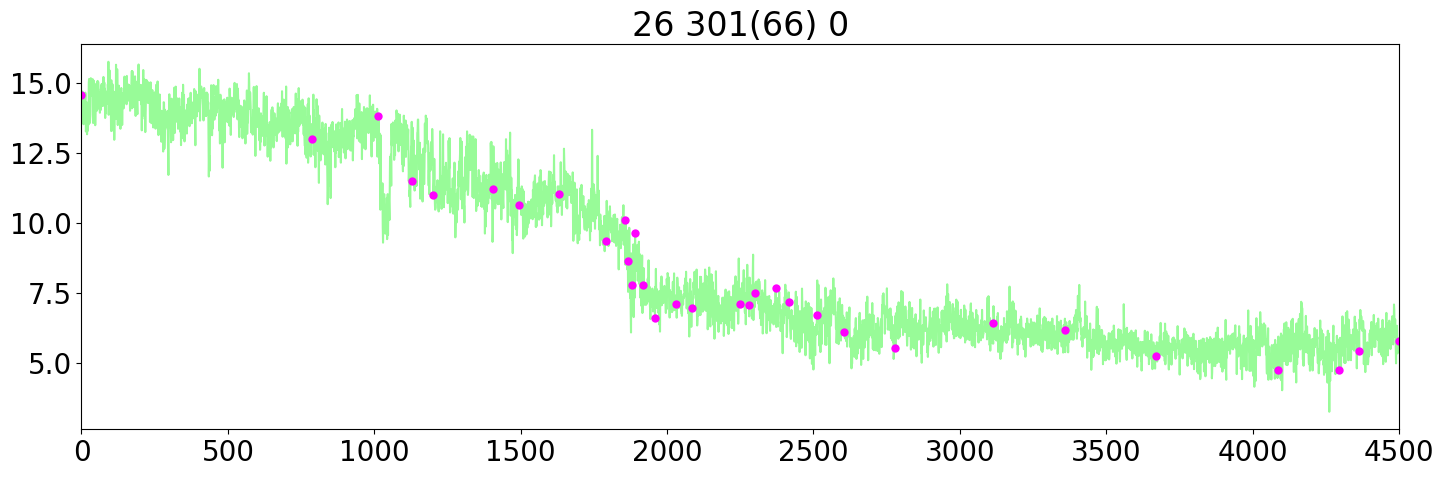

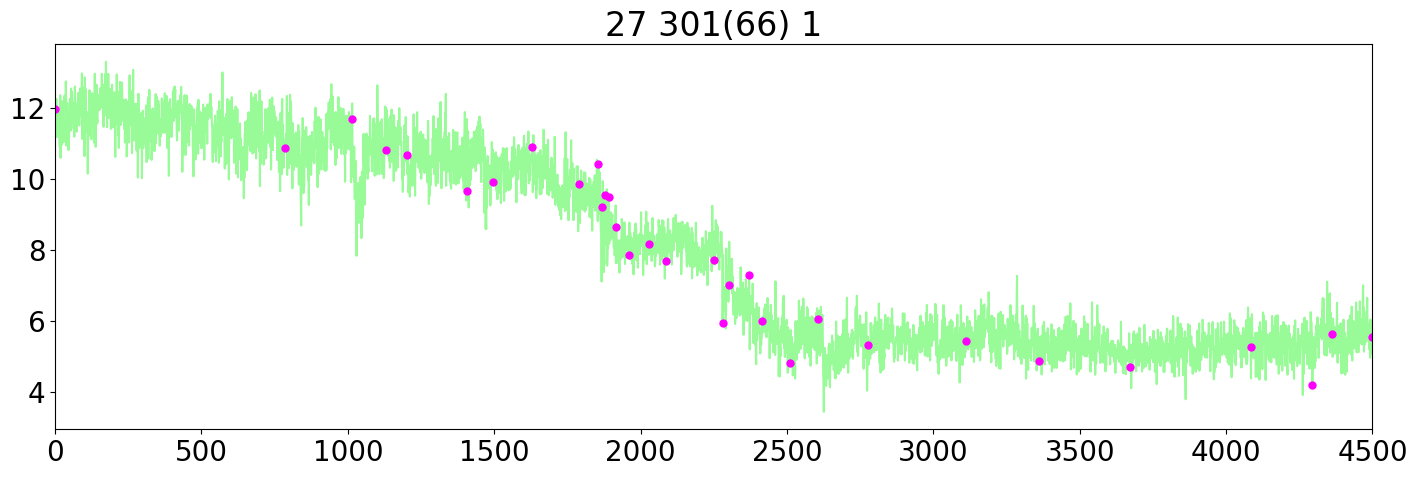

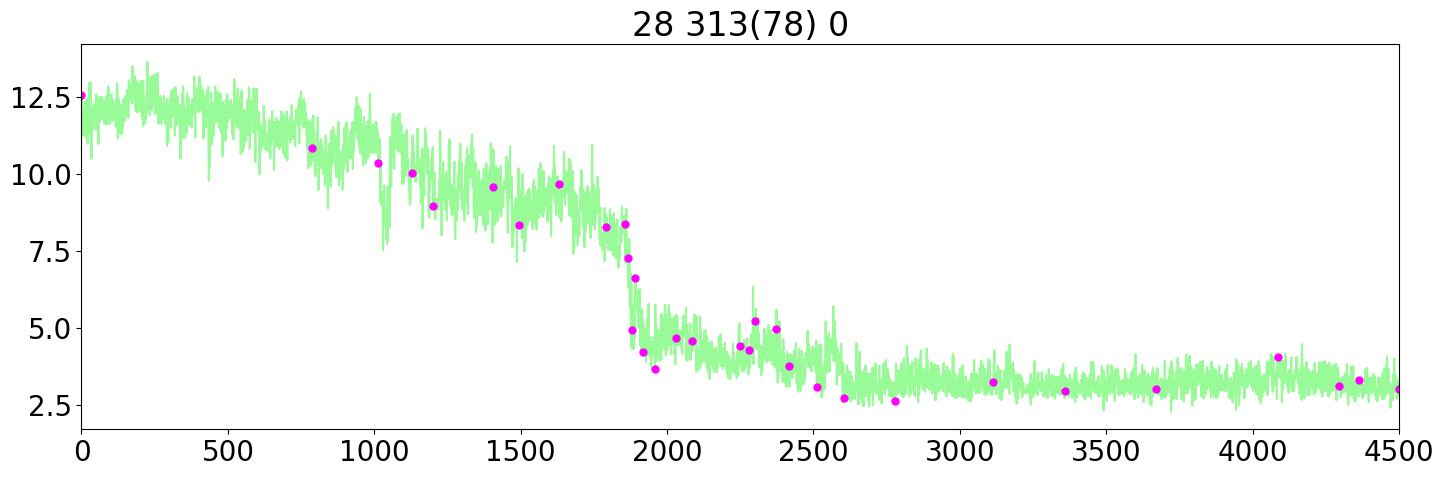

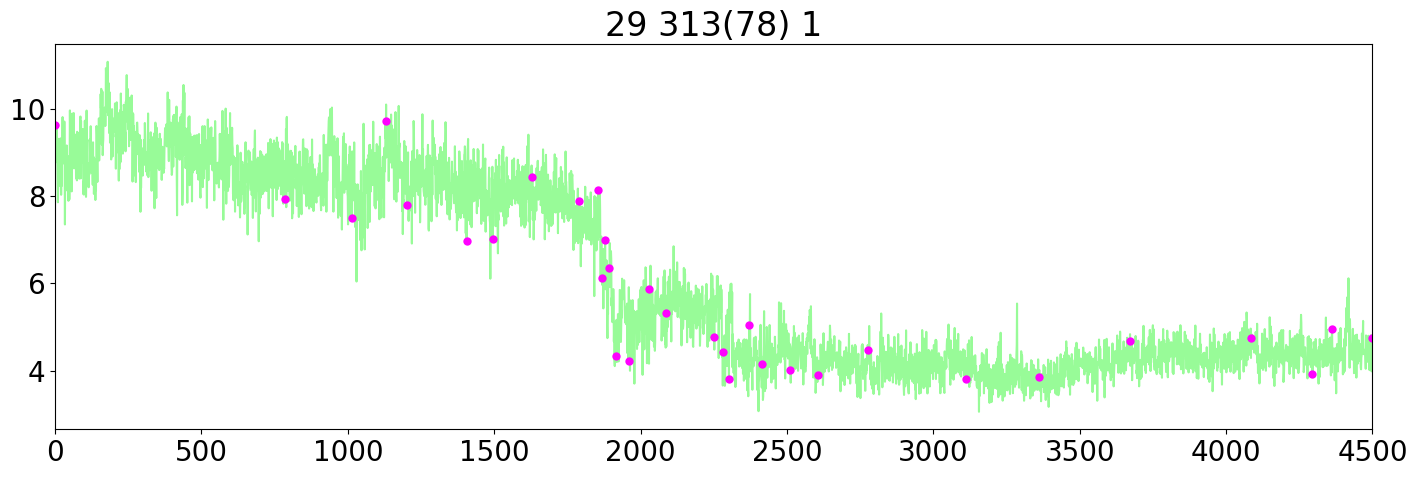

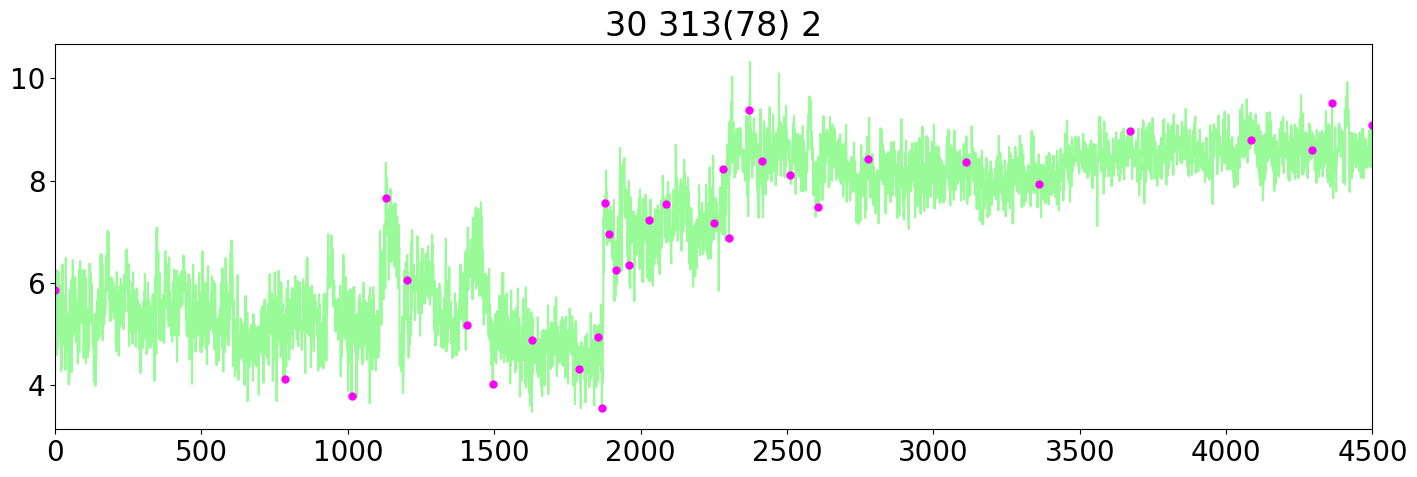

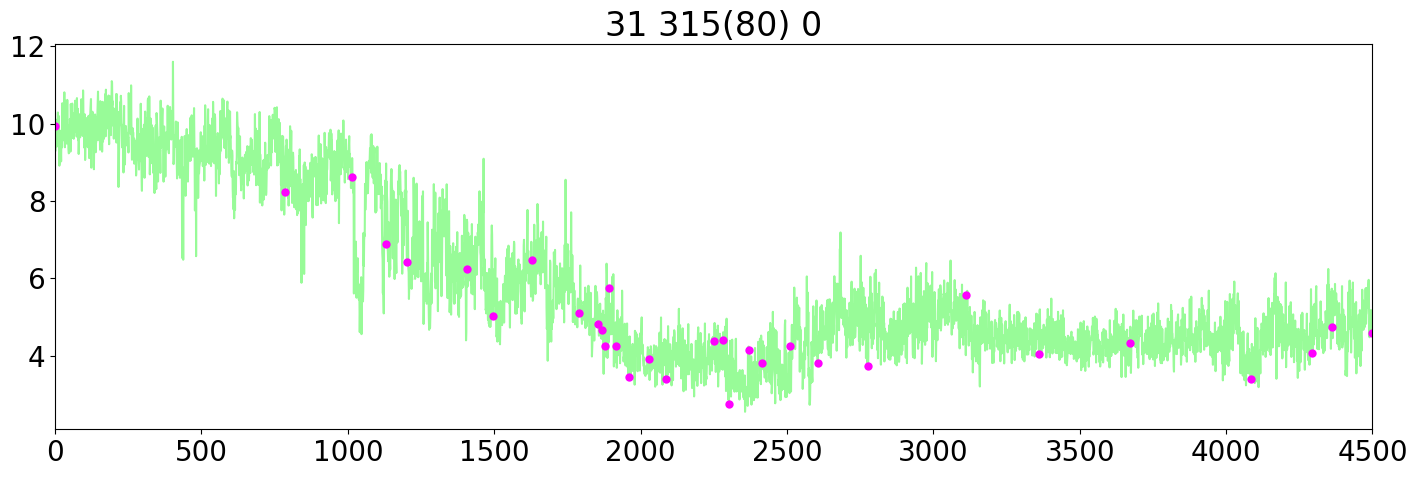

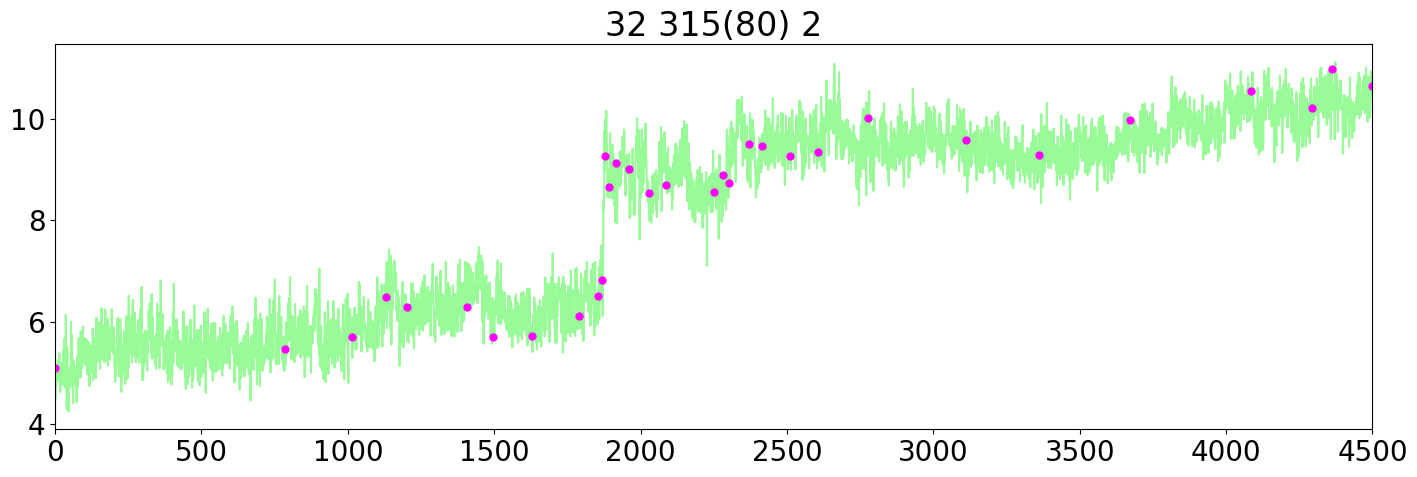

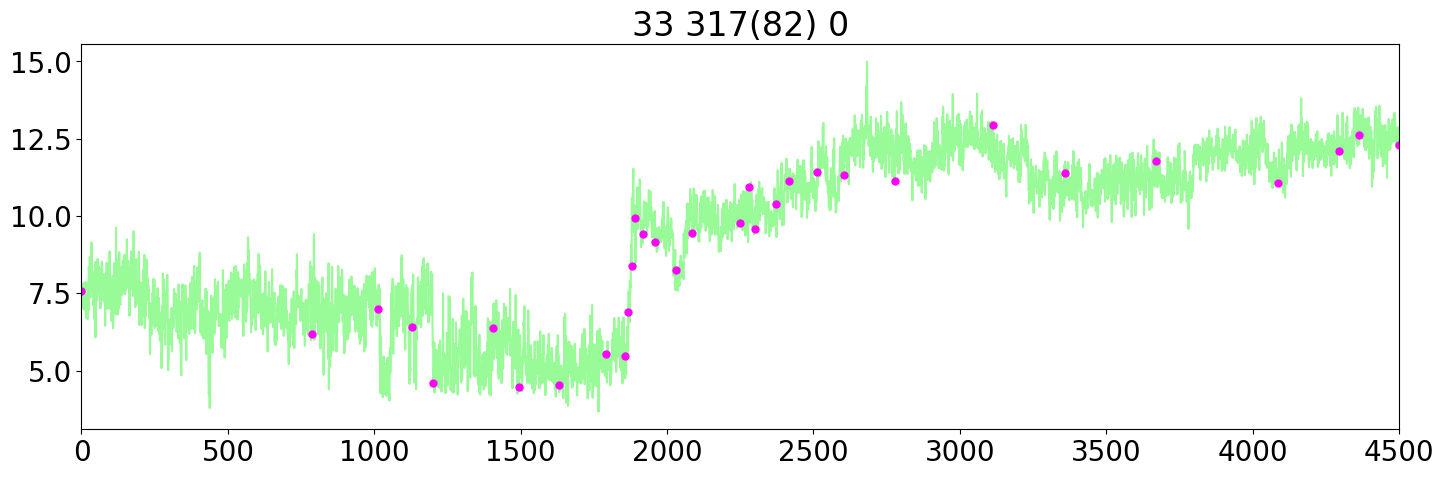

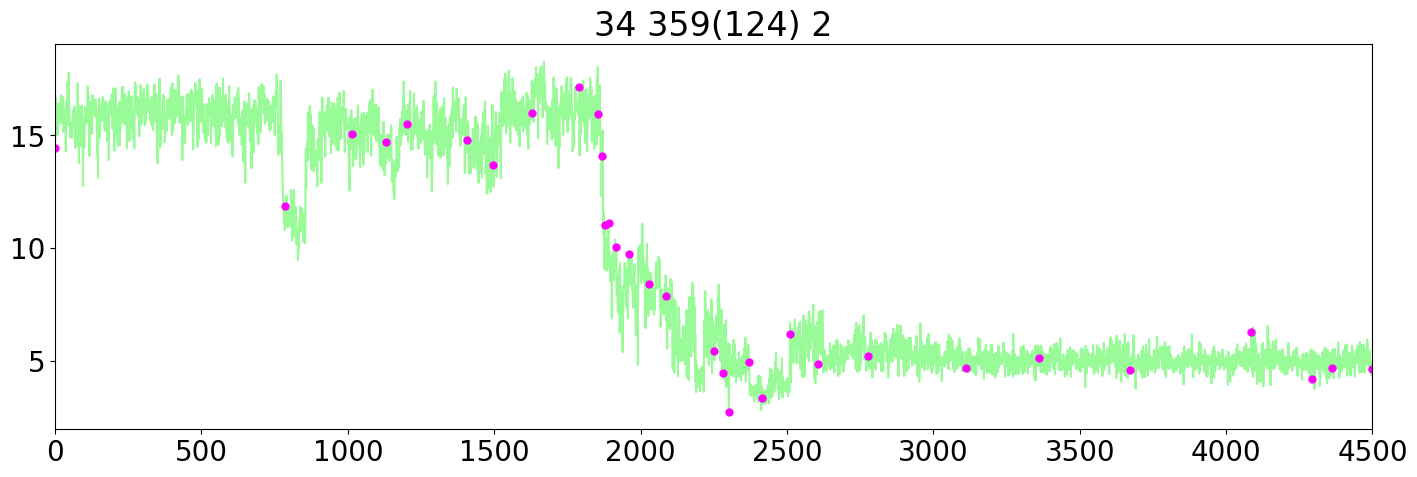

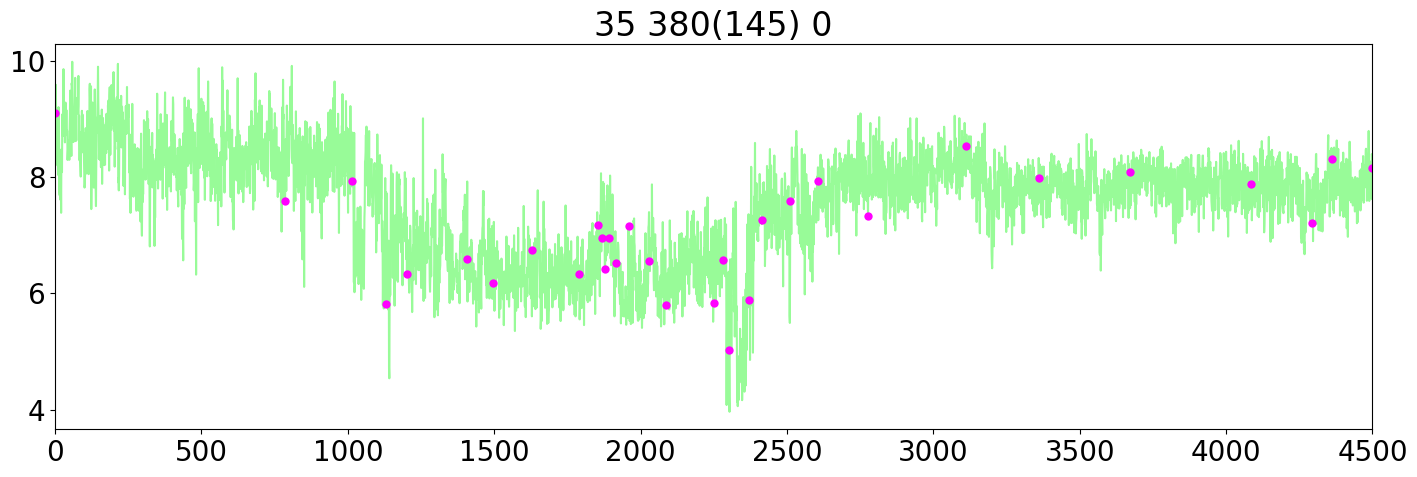

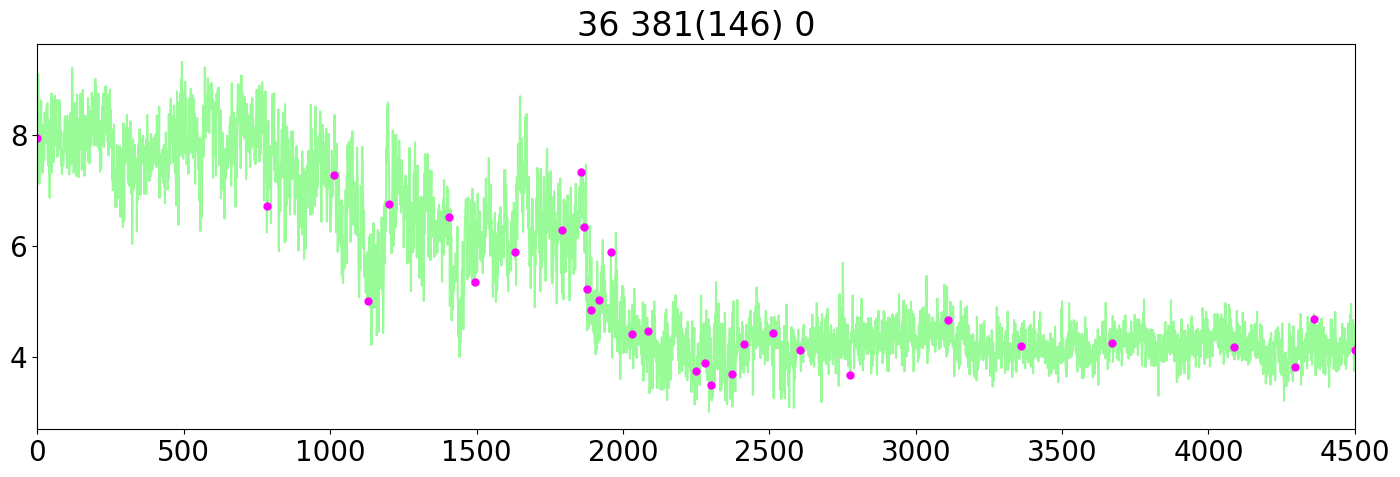

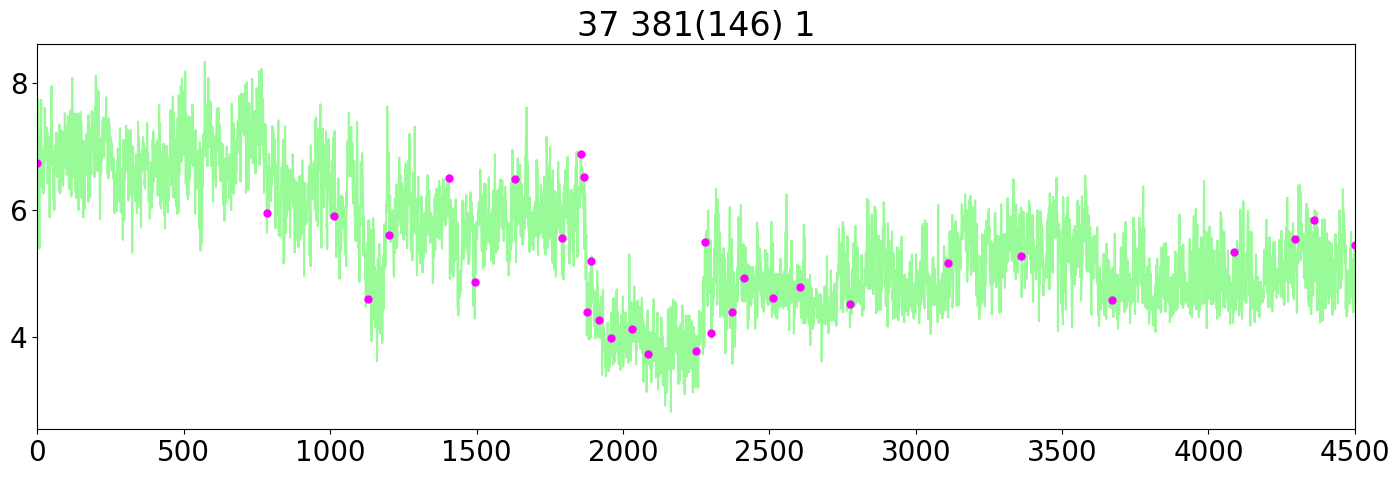

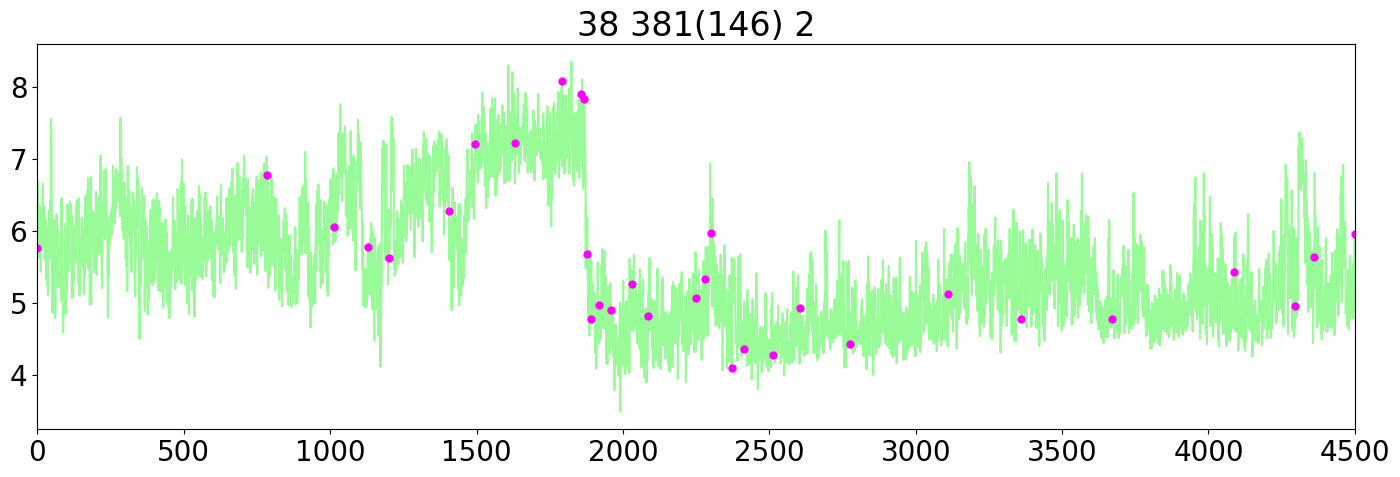

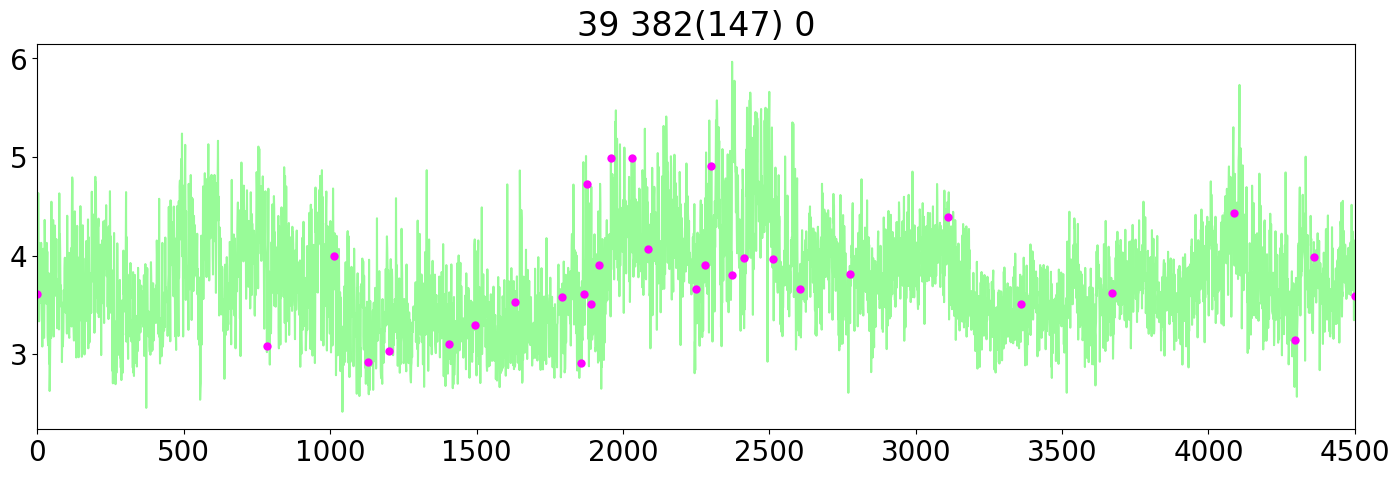

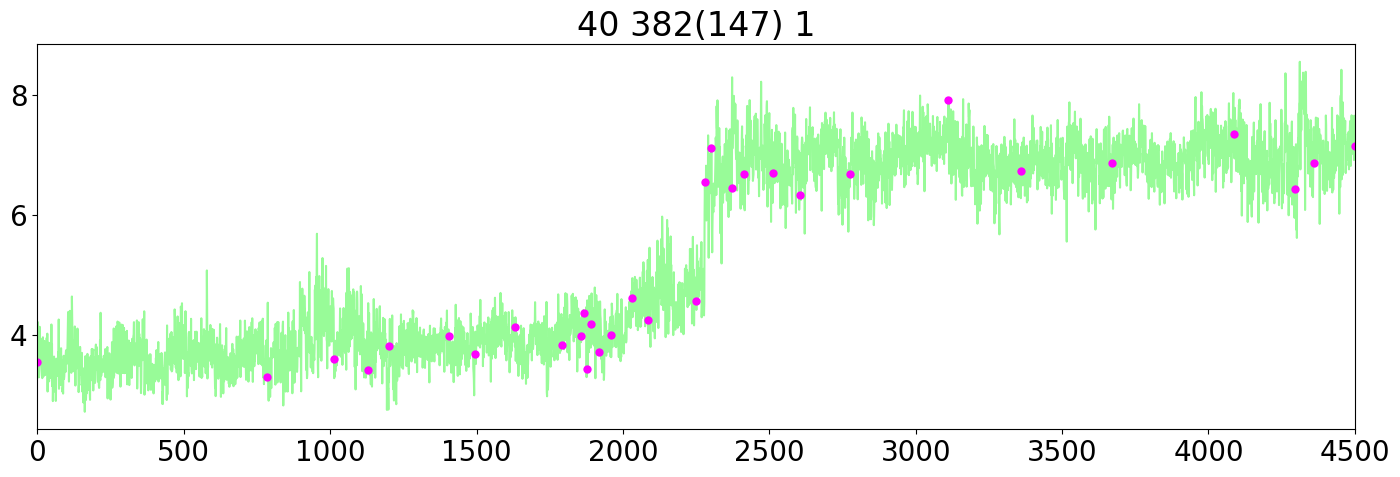

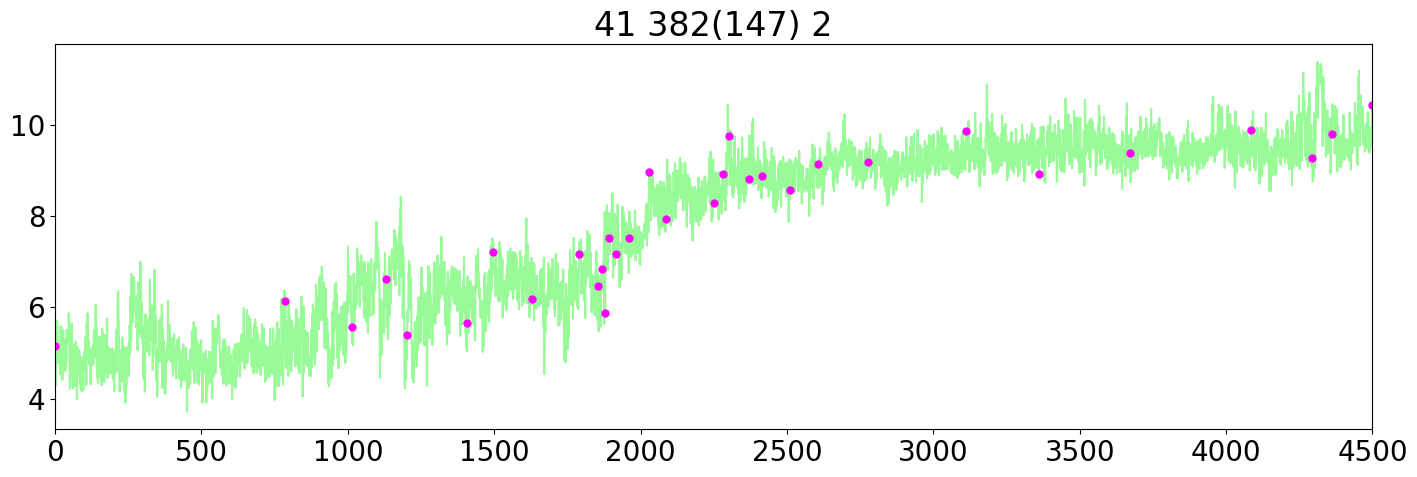

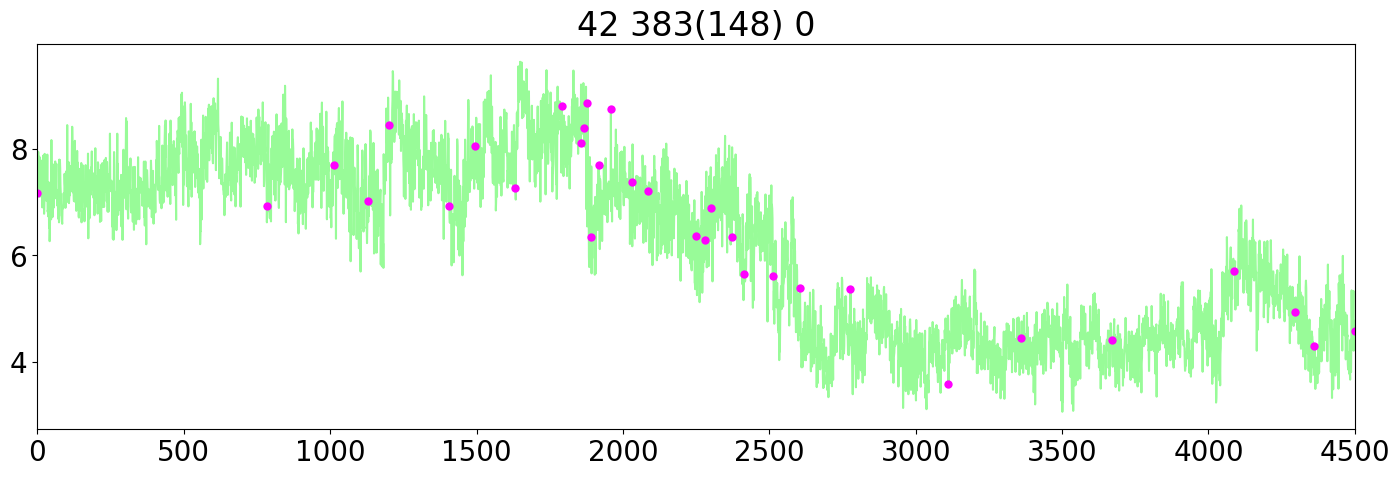

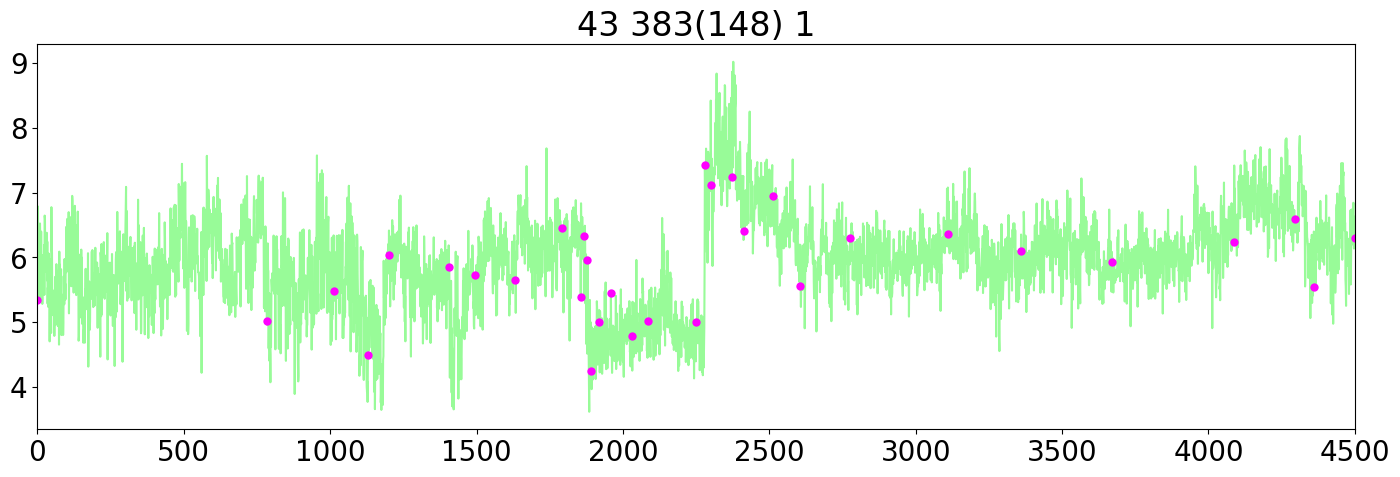

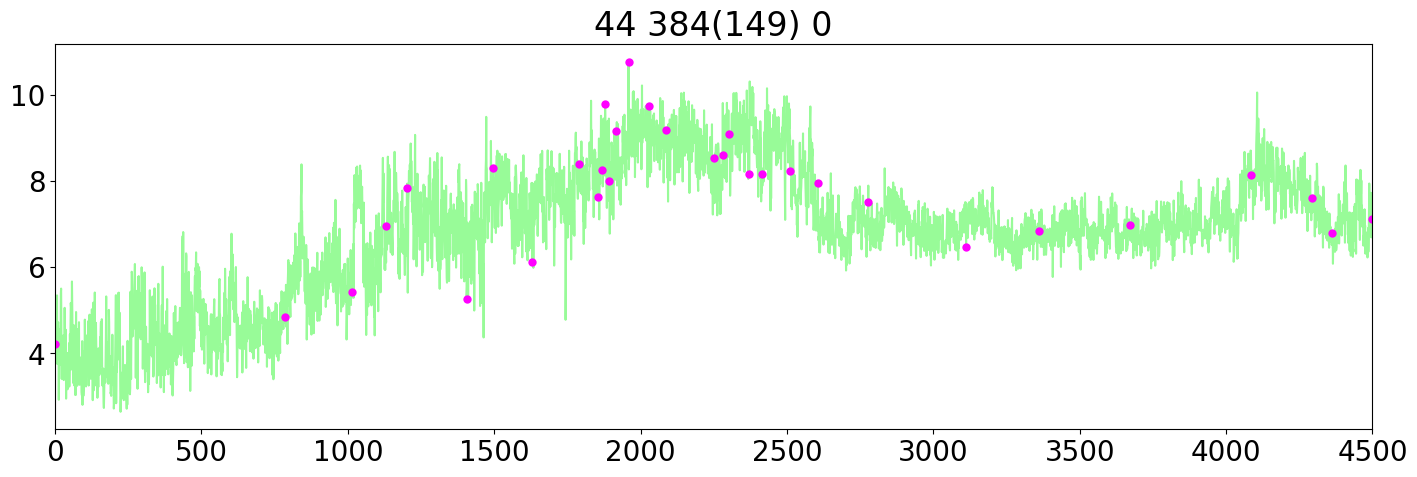

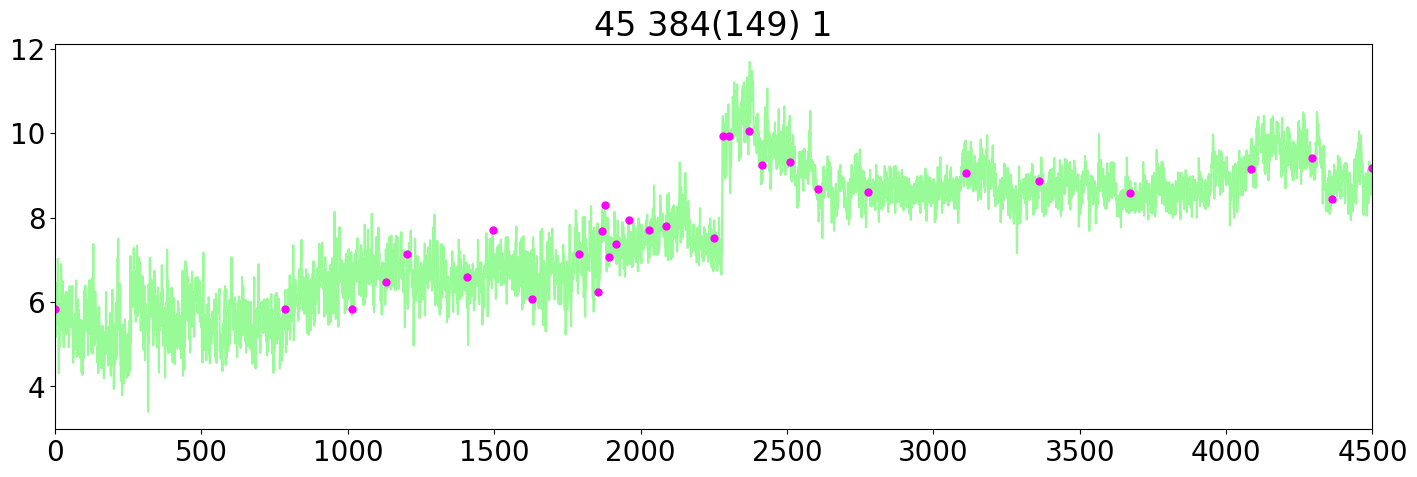

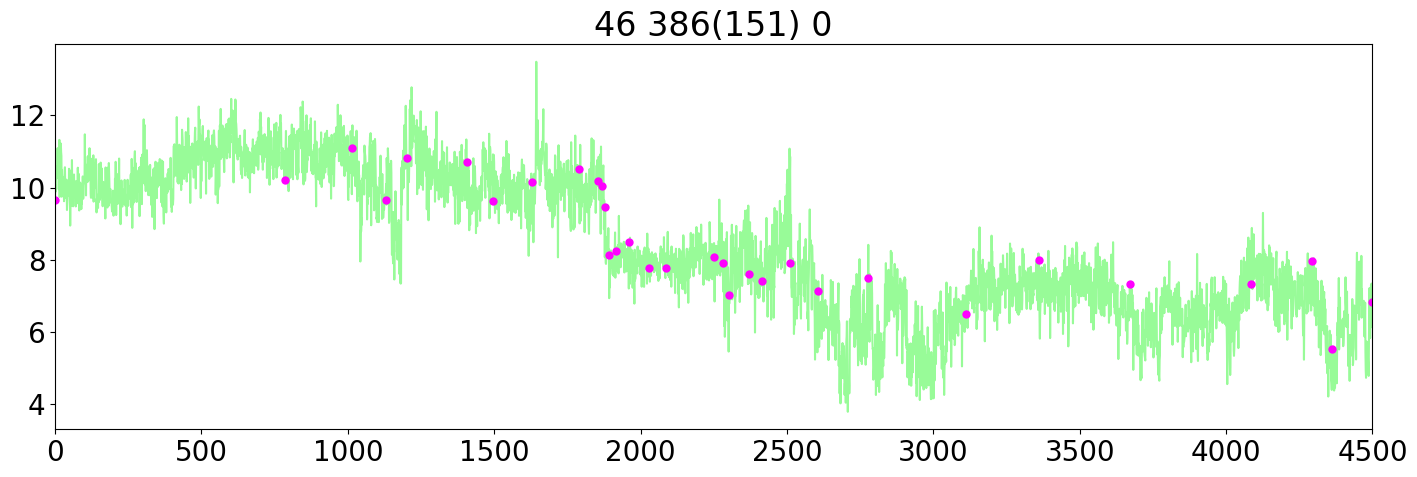

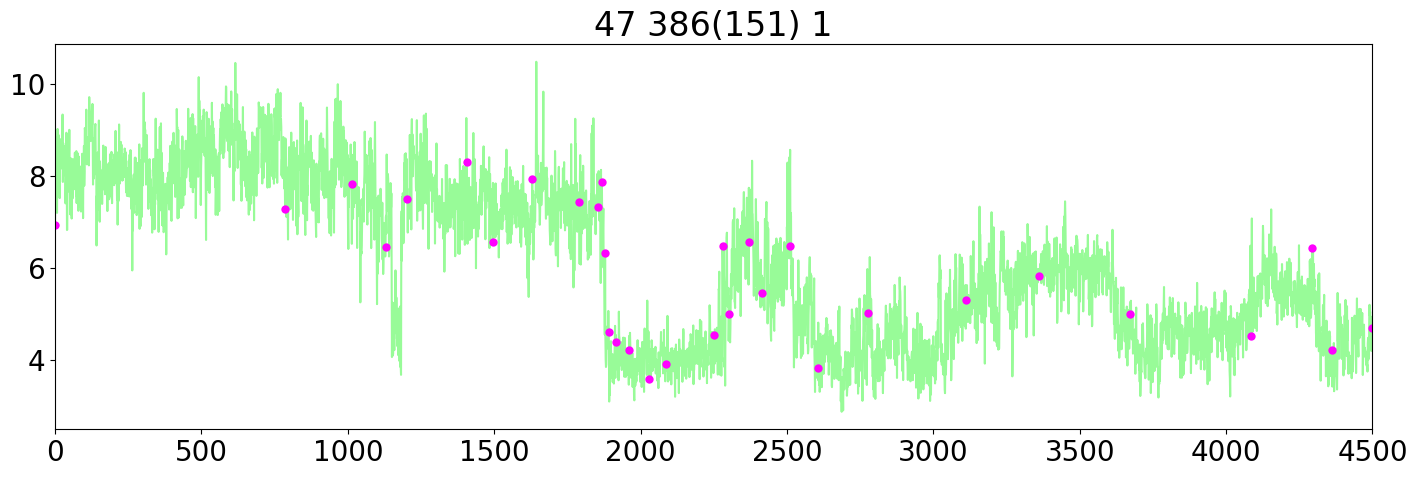

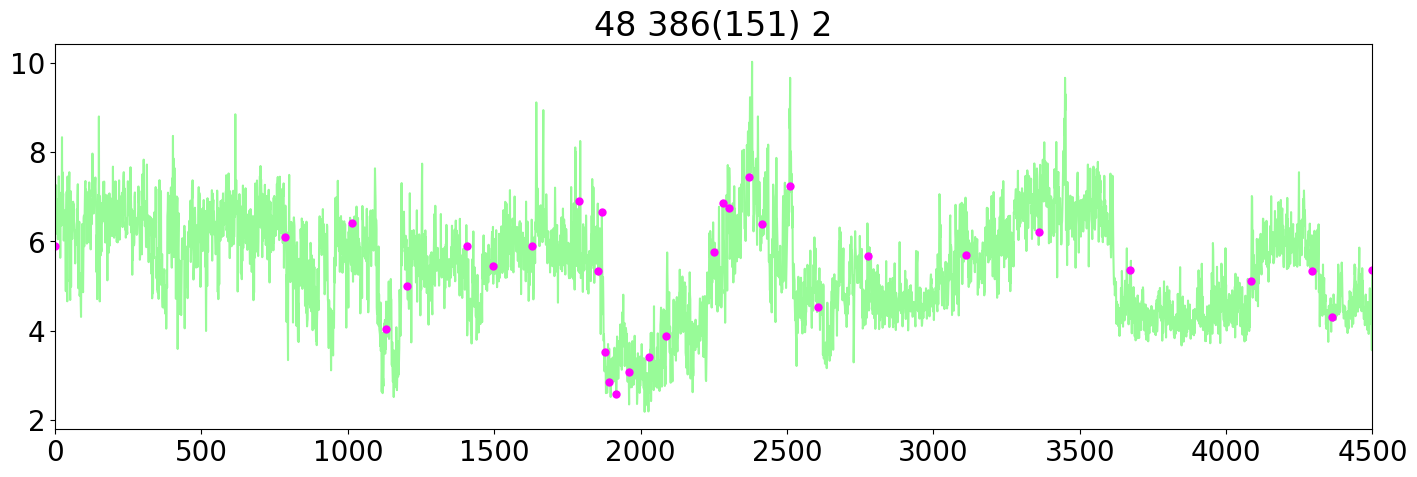

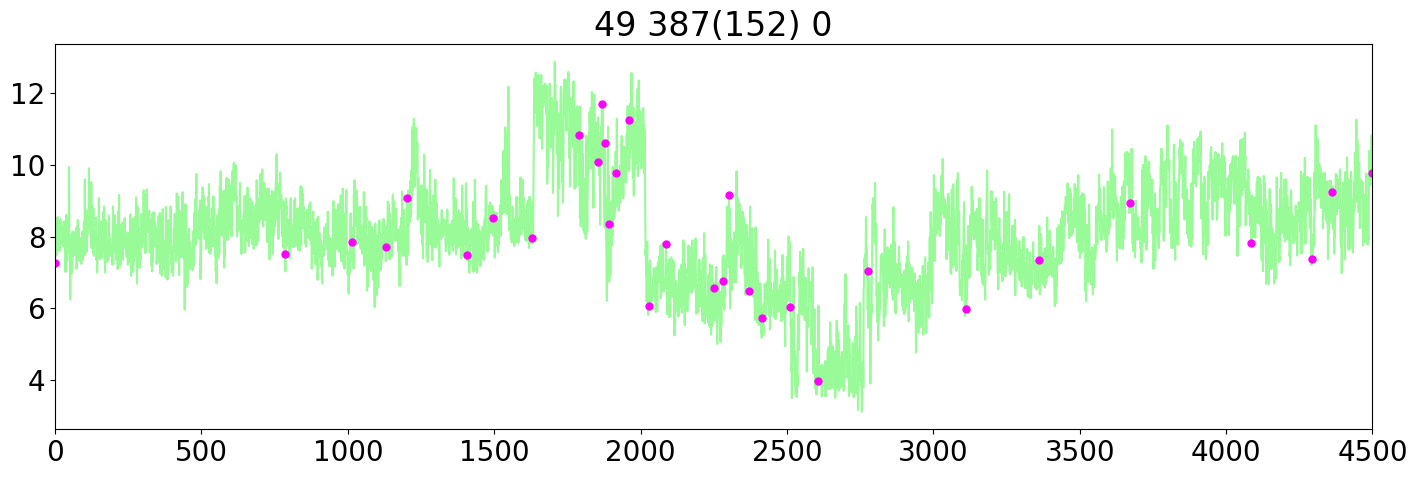

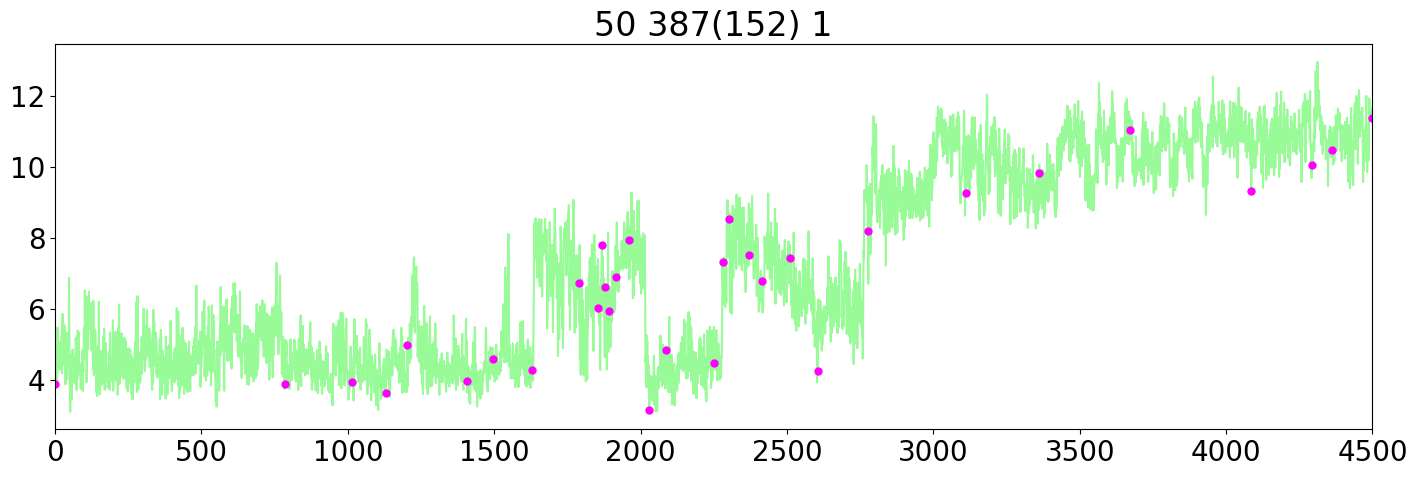

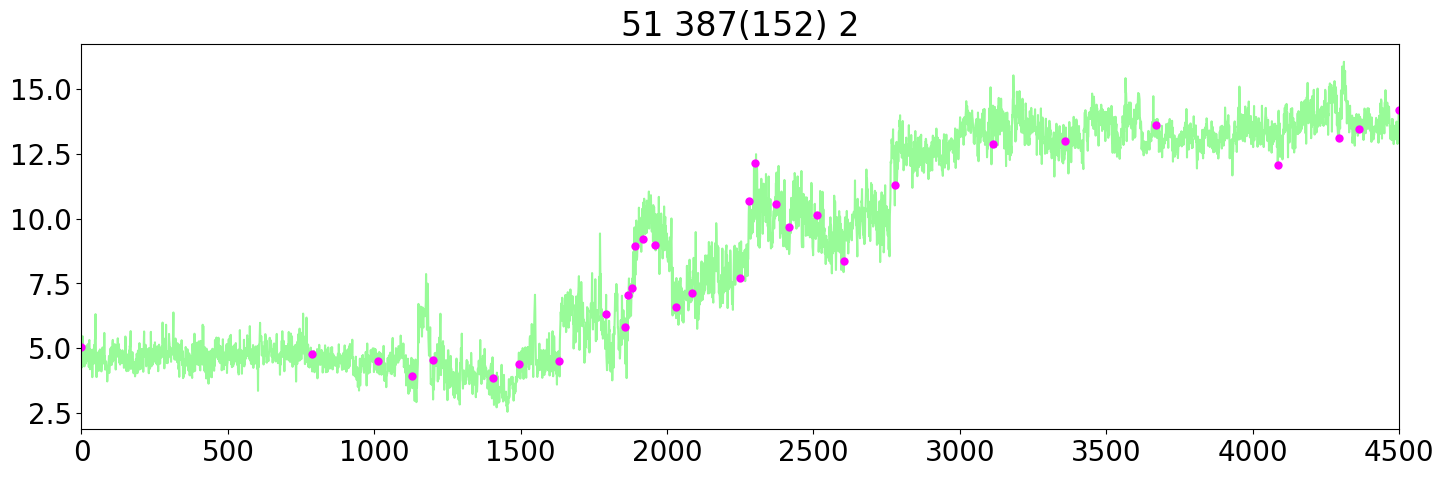

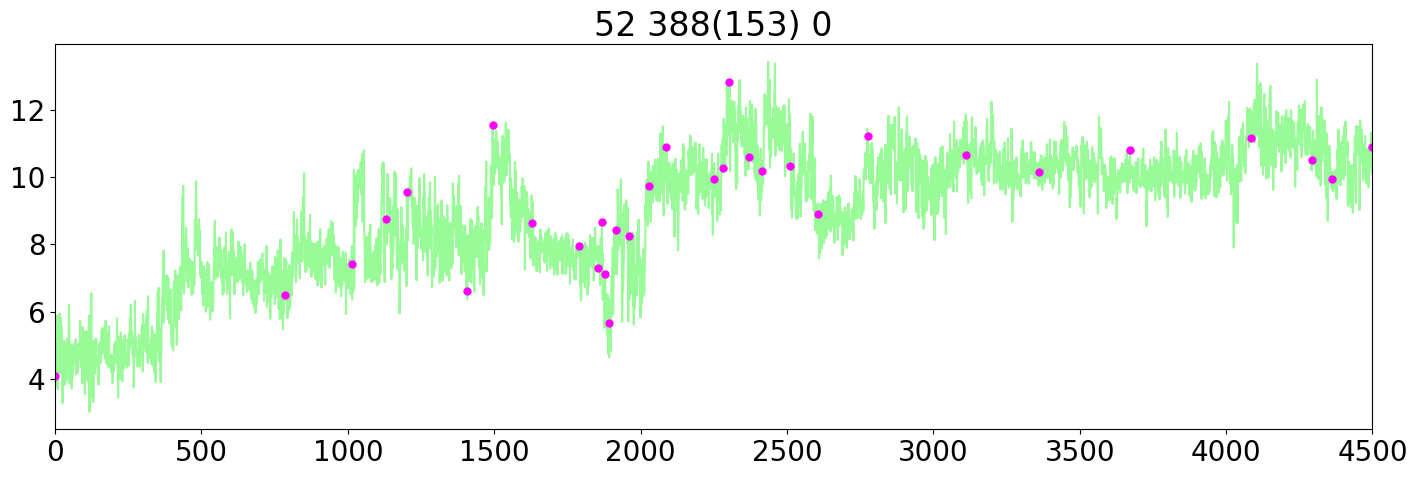

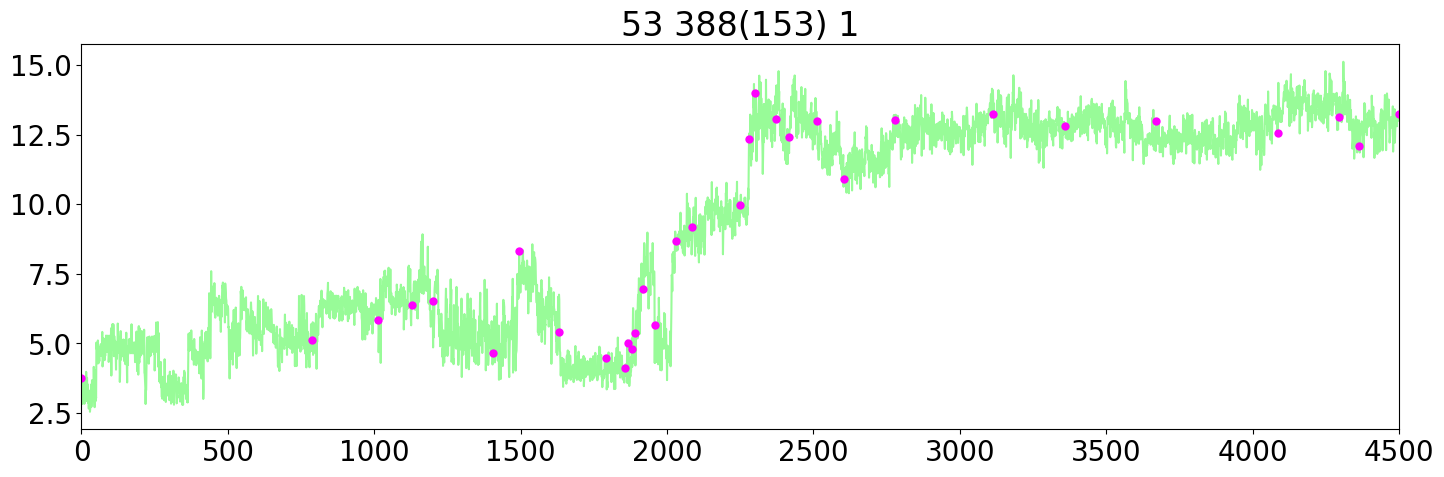

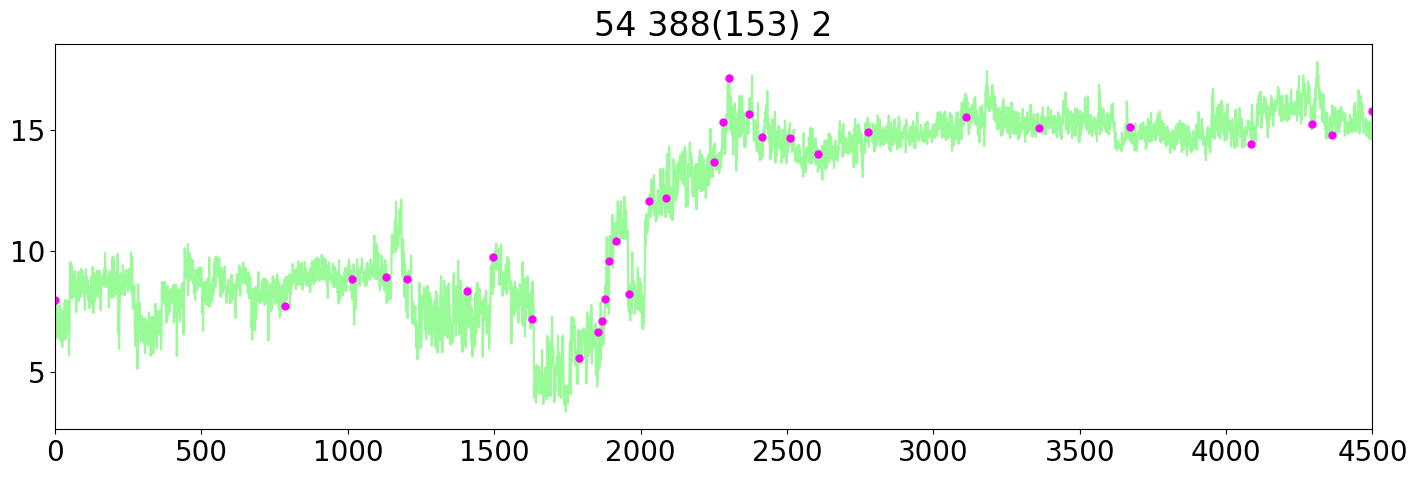

In [31]:
'''Plot distribution of sel_frames along CVs in original trajectory'''

label_points = []
for i,(frag,res) in enumerate(contact_list):
    plt.figure(figsize=(17,5))
    plt.title(str(i)+" "+str(res)+"("+str(resid_to_index(res))+") "+str(frag))
    plt.xlim(0,featurized.shape[2])
#     plt.xticks(range(0,featurized.shape[2],1000), rotation=90)
    plt.plot(featurized[resid_to_index(res),frag], color='palegreen', 
             markevery=sel_frames, marker='o', mfc='magenta', mew=0)
    for x in label_points:
        y = featurized[resid_to_index(res),frag][x]
        plt.text(x,y+1,str(x), fontsize=12)
    plt.show()

### Create .coor and .xsc files for each image

In [32]:
n_images = len(sel_frames)

# os.makedirs("./setup", exist_ok=False)
#os.makedirs("./output", exist_ok=False)
#for i in range(n_images):
#    os.makedirs("./output/"+str(i), exist_ok=False)

for i,frame in enumerate(np.asarray(sel_frames)+14000):
    filename = "image_"+str(i)+".coor"
    command = catdcdPath+" -o ./setup/"+filename+" -otype namdbin -stype psf -s "+psfFile+ \
        " -first "+str(frame+1)+" -last "+str(frame+1)+" -dcd "+dcdFile
    process = subprocess.Popen(command, shell=True)
    process.wait()
    
    # build xsc files from coordinates recorded in dcd, and manually specify origin
    # Done in response to a whole bunch of issues that shouldn't normally happen, should just use xst?
    sedFile = setupPath + "image_"+str(i)+".xsc"
    tmpFile = open(sedFile,"w")
    tmpFile.write("""# NAMD extended system trajectory file
#$LABELS step a_x a_y a_z b_x b_y b_z c_x c_y c_z o_x o_y o_z
""")
    box_length = string_traj[i].unitcell_lengths[0][0]*10
    origin = box_length/2
    tmpFile.write(str(frame)+" "+str(box_length)+" 0 0 0 "+str(box_length)+" 0 0 0 "+str(box_length)+" "+str(origin)+" "+str(origin)+" "+str(origin)+" 0 0 0 0 0 0")
    tmpFile.close()
    # Now we get the data from the chosen frame and append it to the file for the current image.
    # sedLine = "cat "+xstFile+" | grep -v ^# | sed -n "+str(frame + 1)+"p >> "+ sedFile 
    # process = subprocess.Popen(sedLine, shell=True)
    # process.wait()

CatDCD 5.2
psfplugin) Detected a Charmm PSF file
psfplugin) Detected a Charmm PSF EXTEnded file
Opening file './setup/image_0.coor' for writing.
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
Opened file './pull_traj/slow_run_14_full.dcd' for reading.
Read 14001 frames from file ./pull_traj/slow_run_14_full.dcd, wrote 1.
Total frames: 14001
Frames written: 1
CatDCD exited normally.
CatDCD 5.2
psfplugin) Detected a Charmm PSF file
psfplugin) Detected a Charmm PSF EXTEnded file
Opening file './setup/image_1.coor' for writing.
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
Opened file './pull_traj/slow_run_14_full.dcd' for reading.
Read 14787 frames from file ./pull_traj/slow_run_14_full.dcd, wrote 1.
Total frames: 14787
Frames written: 1
CatDCD exited normally.
CatDCD 5.2
psfplugin) Detected a Charmm PSF file
psfplugin) Detected a C

CatDCD 5.2
psfplugin) Detected a Charmm PSF file
psfplugin) Detected a Charmm PSF EXTEnded file
Opening file './setup/image_18.coor' for writing.
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
Opened file './pull_traj/slow_run_14_full.dcd' for reading.
Read 16281 frames from file ./pull_traj/slow_run_14_full.dcd, wrote 1.
Total frames: 16281
Frames written: 1
CatDCD exited normally.
CatDCD 5.2
psfplugin) Detected a Charmm PSF file
psfplugin) Detected a Charmm PSF EXTEnded file
Opening file './setup/image_19.coor' for writing.
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
Opened file './pull_traj/slow_run_14_full.dcd' for reading.
Read 16303 frames from file ./pull_traj/slow_run_14_full.dcd, wrote 1.
Total frames: 16303
Frames written: 1
CatDCD exited normally.
CatDCD 5.2
psfplugin) Detected a Charmm PSF file
psfplugin) Detected a

### Create _configuration_ files

In [33]:
# double {{ is required as escape for string.format()
colvarBlock = """
colvar {{
    name swarms_cv{CVNUM}
    distance {{
        group1 {{
            atomNumbers {{ {GROUP1} }}
        }}
        group2 {{
            atomNumbers {{ {GROUP2} }}
        }}
    }}
}}

harmonic {{
    name bias_swarms_cv{CVNUM}
    colvars swarms_cv{CVNUM}
    centers {CENTER}
    forceConstant 0.0
}}

"""

In [34]:
# substitute CV values into text block, centers rounded to 4 decimal places
# Note that NAMD colvar files are 1-indexed, where all calculations above are 0-indexed
for i in range(len(sel_frames)):
    with open(setupPath+"image_"+str(i)+"_colvars.conf", 'w') as f:
        for key in CV_info.keys():
            f.write(colvarBlock.format(CVNUM = key,
                                       GROUP1 = " ".join([str(j) for j in np.asarray(CV_info[key]["a"])+1]),
                                       GROUP2 = " ".join([str(j) for j in np.asarray(CV_info[key]["b"])+1]),
                                       CENTER = round(CV_info[key]["CV_points"][sel_frames[i]],4)))


# Run string calculation

#### If not from a steered MD trajectory, use setup/*colvars.conf files to run equilibrations
#### Check system alignment! Trust nothing!